In [1]:
import os, json, argparse, random, numpy as np, torch
import seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from whobpyt.data_loader import BOLDDataLoader, DEVICE
from simulators.rww_simulator import RWWSubjectSimulator
from whobpyt.custom_cost_RWW import CostsRWW
from whobpyt.modelfitting import Model_fitting
from whobpyt.models.fc_cnn_disc import FCCNNDisc
from whobpyt.utils.plotter import heatmap_fc

Using DEVICE = cuda


In [2]:
def build_generator(loader, subj, *, chunk, g0, step, lr, epochs,
                    fit_g_EE=True, fit_g_EI=True, save_path=None):
    sc = loader.get_subject_connectome(subj, norm=True)
    sim = RWWSubjectSimulator(
        sc, sc.shape[0],
        TP_per_window=chunk,
        fit_g_EE=fit_g_EE, fit_g_IE=False, fit_g_EI=fit_g_EI,
        use_fic=False, step_size=step, g_init=g0)
    sim.model.to(DEVICE)

    full_emp = torch.tensor(np.corrcoef(loader.all_bold[subj]), dtype=torch.float32, device=DEVICE)
    cost = CostsRWW(sim.model, use_rate_reg=True, lambda_rate=0.05,
                    use_spec_reg=True, lambda_spec=0.05,
                    use_disp_reg=True, lambda_disp=0.03)
    fitter = Model_fitting(sim.model, cost, device=DEVICE)
    fitter.train(u=0,
                 empFcs=[full_emp],
                 num_epochs=epochs,
                 num_windows=loader.all_bold[subj].shape[1] // chunk,
                 learningrate=lr,
                 early_stopping=True)
    
    if save_path:
        torch.save(sim.model.state_dict(), save_path)
    return sim

In [3]:
torch.manual_seed(0); np.random.seed(0)

data_root ="/vol/bitbucket/ank121/fyp/HCP Data"
gen_path = "/vol/bitbucket/ank121/whobpyt/discriminator_weights/gen_sub18"
save_gen = True
chunk = 200
epochs_gen = 20
epochs_disc = 5
batch = 16
subj = 18

# load data
fmri = os.path.join(data_root, "BOLD Timeseries HCP.mat")
loader = BOLDDataLoader(fmri, os.path.join(data_root, "distance_matrices"), os.path.join(data_root, "schaefer100_dist.npy"), chunk_length=chunk)
loader._split_into_chunks()

generator_save_path = f"{gen_path}_{chunk}.pt"
# Build / load generator
if save_gen and Path(generator_save_path).exists():
    sc = loader.get_subject_connectome(subj, norm=True)
    sim = RWWSubjectSimulator(sc, sc.shape[0], TP_per_window=chunk,
                                fit_g_EE=True, fit_g_IE=False, fit_g_EI=True,
                                use_fic=True, step_size=0.05, g_init=1000)
    sim.model.load_state_dict(torch.load(generator_save_path, map_location=DEVICE))
    sim.model.to(DEVICE)
    print(f"[+] Generator loaded from {generator_save_path}")
else:
    print("[+] Training generator")
    sim = build_generator(loader, subj,
                            chunk=chunk, g0=1000, step=0.05,
                            lr=0.1, epochs=epochs_gen,
                            save_path=generator_save_path)
    print(f"[+] Generator saved to {gen_path}")

[DataLoader] Loaded 100 subjects.
[DataLoader] Created 500 chunks (chunk length = 200).
[+] Generator loaded from /vol/bitbucket/ank121/whobpyt/discriminator_weights/gen_sub18_200.pt


In [4]:
def get_empirical_batch(loader, subj, chunk, B):
    """ Return B empirical FCs """
    ts = loader.all_bold[subj]
    idxs = np.random.randint(0, ts.shape[1] - chunk + 1, size=B)
    fc_list = [np.corrcoef(ts[:, i:i+chunk]) for i in idxs]
    return torch.tensor(np.stack(fc_list), dtype=torch.float32, device=DEVICE)


def get_simulated_batch(sim, chunk, n_rep, B):
    """ Run n_rep full simulations, cut into chunks, pick B at random """
    fc_pool = []
    usable = (1200 // chunk) * chunk
    for _ in range(n_rep):
        ts, _ = sim.simulate(u=0, num_windows=usable // chunk, base_window_num=10)
        
        print("Sim TS mean/std:", ts.mean(), ts.std())

        idxs = np.random.randint(0, ts.shape[1] - chunk + 1, size=max(B // n_rep + 1, 1))
        fc_pool.extend([np.corrcoef(ts[:, j:j+chunk]) for j in idxs])
    fc_pool = np.stack(fc_pool[:B])
    return torch.tensor(fc_pool, dtype=torch.float32, device=DEVICE)



=== CHUNK 50 TR ===
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.1620238 0.5460974
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.1645348 0.5429281
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.1650152 0.5438141
call1    | mean +0.0104  std 0.3396
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.1673777 0.5450699
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.1680367 0.5440367
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.166339 0.54277396
call2    | mean +0.0164  std 0.3522
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.1676962 0.5426324
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.167915 0.5436349
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.1629877 0.54323536
call3    | mean +0.0095  std 0.3453
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.1646307 0.5437622
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.167347 0.5439312
[Simulator] Simulating 24 windows 
Sim TS mean/std: 2.1688378 0.54130626
call4  

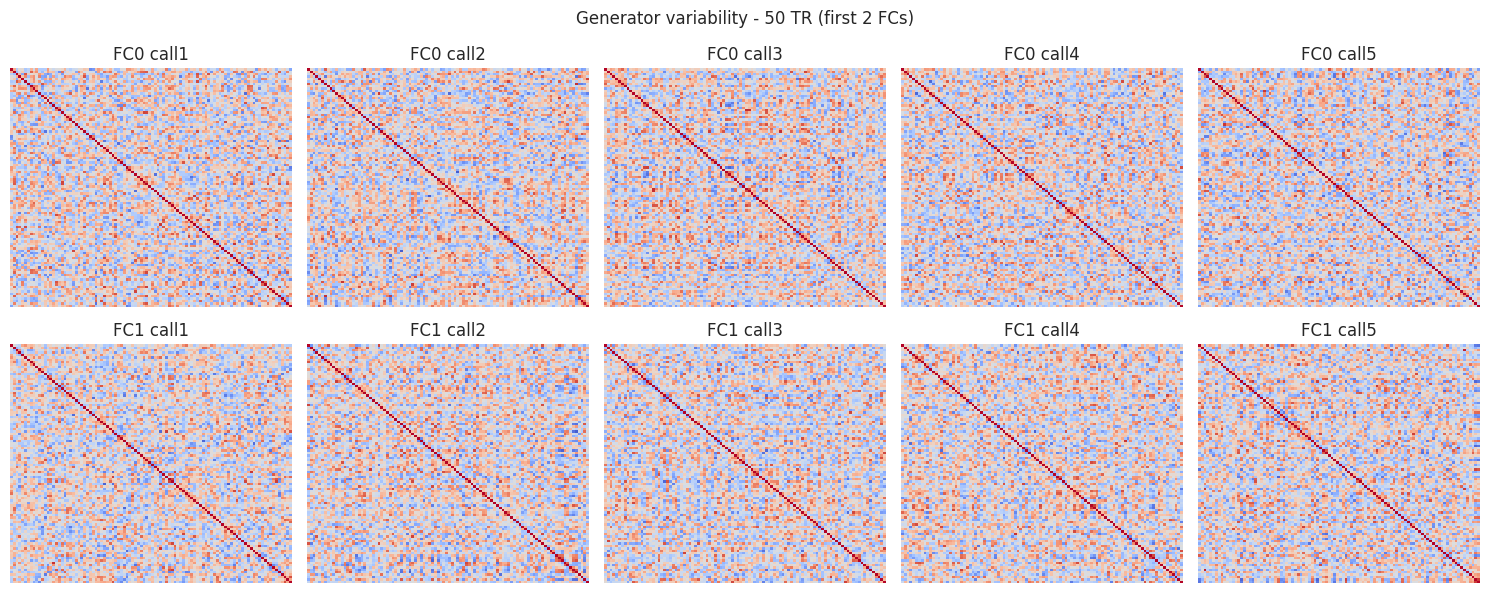


=== CHUNK 100 TR ===
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.1716187 0.5450735
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.1720111 0.5412394
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.169035 0.53999346
call1    | mean +0.0123  std 0.2481
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.1727397 0.5432421
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.176744 0.54424745
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.1580954 0.54291964
call2    | mean +0.0103  std 0.2517
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.1663916 0.5420861
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.1692274 0.5402702
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.1707416 0.54363257
call3    | mean +0.0179  std 0.2558
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.166975 0.54342335
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.1681106 0.54285854
[Simulator] Simulating 12 windows 
Sim TS mean/std: 2.1683412 0.54196745
ca

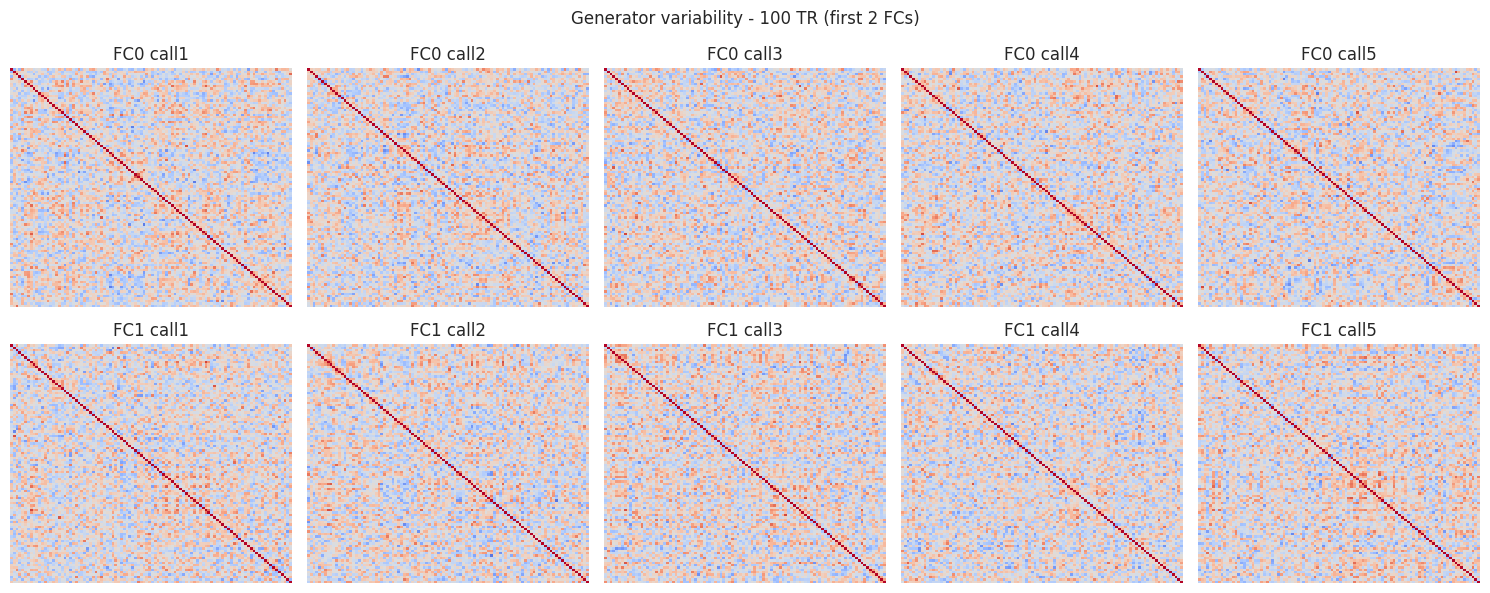


=== CHUNK 200 TR ===
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.164822 0.5424141
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.164813 0.54137385
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1613193 0.5434913
call1    | mean +0.0071  std 0.1783
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1718156 0.5474833
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.166914 0.5458783
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1632373 0.5452452
call2    | mean +0.0188  std 0.1801
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.170609 0.54764616
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1638048 0.54287326
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1739695 0.5389674
call3    | mean +0.0098  std 0.1800
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1596432 0.54638606
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1592255 0.54714173
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1665244 0.54678416
call4    | mean 

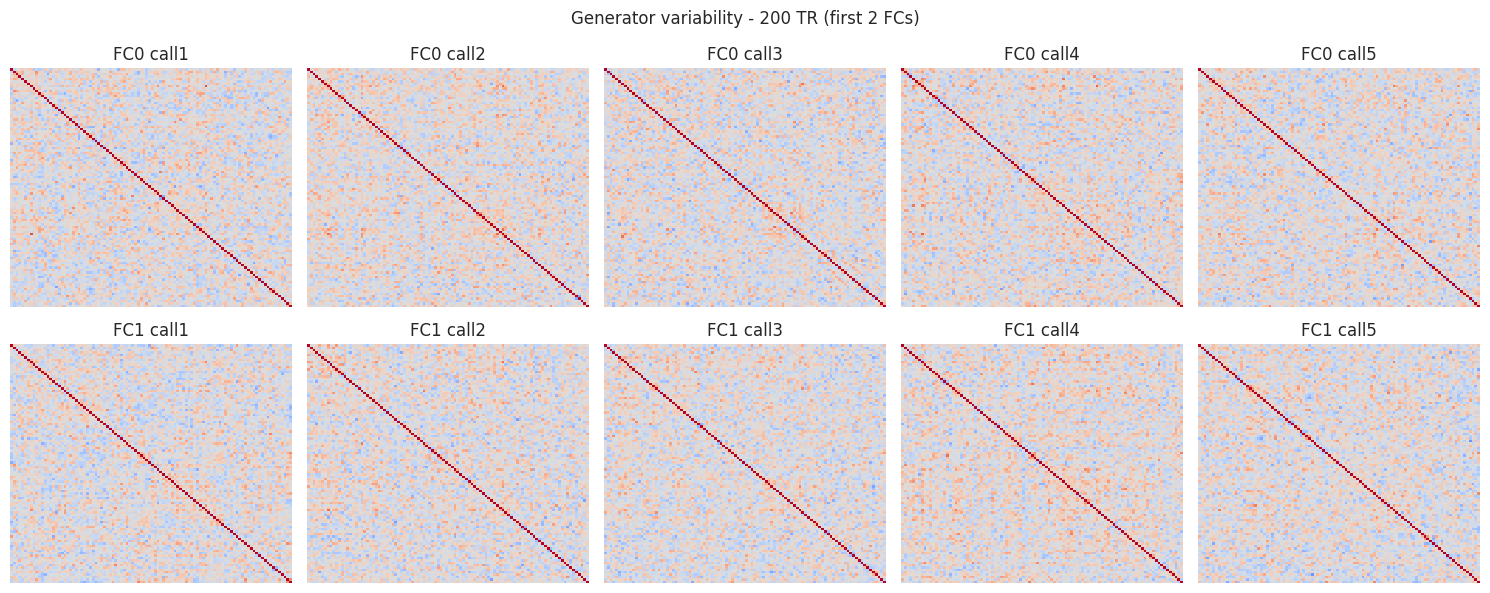


=== CHUNK 400 TR ===
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.1585677 0.5451903
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.1725094 0.54462963
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.1611164 0.54520094
call1    | mean +0.0102  std 0.1279
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.1684418 0.542135
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.1638432 0.54179746
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.165699 0.5447
call2    | mean +0.0146  std 0.1266
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.163403 0.5446917
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.1607447 0.5427344
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.1504982 0.5476018
call3    | mean +0.0077  std 0.1272
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.1589358 0.543257
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.171897 0.53743345
[Simulator] Simulating 3 windows 
Sim TS mean/std: 2.1618779 0.54776055
call4    | mean +0.01

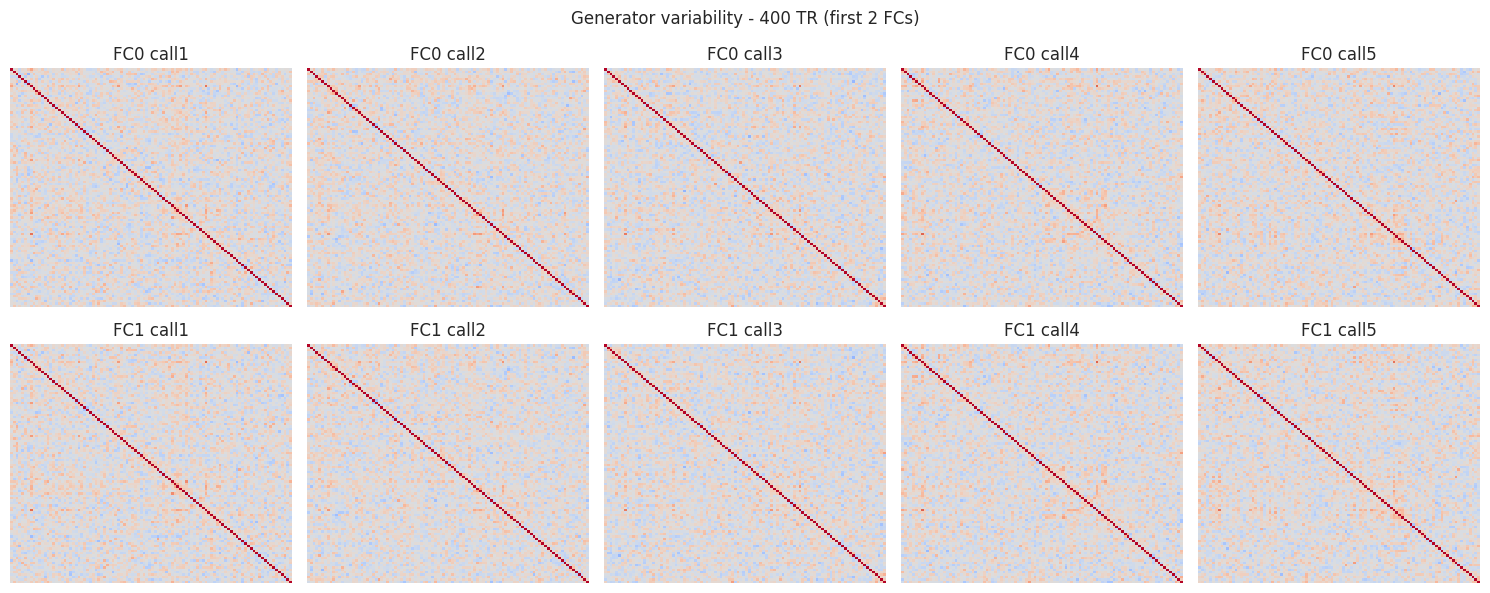

In [5]:
# =========================  VARIABILITY SUITE  =========================
import torch, hashlib, json, itertools, matplotlib.pyplot as plt, seaborn as sns
import numpy as np
from pathlib import Path
from scipy.stats import pearsonr
sns.set_style("white")

# ---------- helpers ----------
def _upper(fc):                       # flatten upper-tri (excl diag)
    n = fc.shape[-1]
    idx = torch.triu_indices(n,n,1, device=fc.device)
    return fc[idx[0], idx[1]]

def _fingerprint(fc):
    """quick hash so we can see if two FCs are byte-identical"""
    h = hashlib.sha1(fc.cpu().numpy().tobytes()).hexdigest()
    return h[:10]

def _describe(batch, tag):
    up = torch.stack([_upper(f) for f in batch])   # (B,M)
    print(f"{tag:<8} | mean {up.mean():+.4f}  std {up.std():.4f}")

# ---------- core test ----------
def variability_suite(sim,                                # trained generator
                      chunks=(50,100,200),                # chunk lengths to probe
                      n_calls=4,                          # how many times to call the fn
                      B=4, n_rep=3,                       # batch size / sims per call
                      save_dir="plots/variability"):      # optional image dump
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    torch.manual_seed(0); np.random.seed(0)

    for chunk in chunks:
        print(f"\n=== CHUNK {chunk} TR ===")
        calls = []
        hashes = []
        for c in range(n_calls):
            fc = get_simulated_batch(sim, chunk, n_rep=n_rep, B=B)  # (B,N,N)
            calls.append(fc)
            hashes.append([_fingerprint(f) for f in fc])
            _describe(fc, f"call{c+1}")

        # ---- pairwise correlations between first element of each call ----
        for (i,j) in itertools.combinations(range(n_calls),2):
            r,_ = pearsonr(_upper(calls[i][0]).cpu(), _upper(calls[j][0]).cpu())
            print(f"  r(call{i+1}-call{j+1}) on FC[0] = {r:+.3f}")

        # ---- check for accidental duplicates (hash collision) -------------
        dup = any(len(set(h))!=len(h) for h in hashes)
        if dup: print("  ⚠️  WARNING: byte-identical FCs found between calls!")

        # ---- quick grid plot ---------------------------------------------
        fig,axs = plt.subplots(2, n_calls, figsize=(3*n_calls,6))
        for c,fc in enumerate(calls):
            sns.heatmap(fc[0].cpu(), vmin=-1, vmax=1, cmap="coolwarm", ax=axs[0,c], cbar=False)
            axs[0,c].set_title(f"FC0 call{c+1}")
            sns.heatmap(fc[1].cpu(), vmin=-1, vmax=1, cmap="coolwarm", ax=axs[1,c], cbar=False)
            axs[1,c].set_title(f"FC1 call{c+1}")
            axs[0,c].axis('off'); axs[1,c].axis('off')
        plt.suptitle(f"Generator variability - {chunk} TR (first 2 FCs)")
        plt.tight_layout(); plt.show()
        plt.savefig(Path(save_dir)/f"var_chunk{chunk}.png"); plt.close()
# ------------------------------------------------------------------------
s
# ▶ run it
variability_suite(sim, chunks=[50,100,200,400], n_calls=5, B=4, n_rep=3)


Testing variability across multiple calls to get_simulated_batch()...

[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1661837 0.5451434
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1534483 0.5483636
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1615565 0.5412329
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1640408 0.5428552
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1708353 0.54206365
Batch 1: mean=0.0186, std=0.2065
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1735678 0.54784024
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1577728 0.54484355
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.16634 0.5457542
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.168616 0.5426854
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1713548 0.5394242
Batch 2: mean=0.0253, std=0.2053
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1699364 0.5400847
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1644678 0.54362154
[Simulator

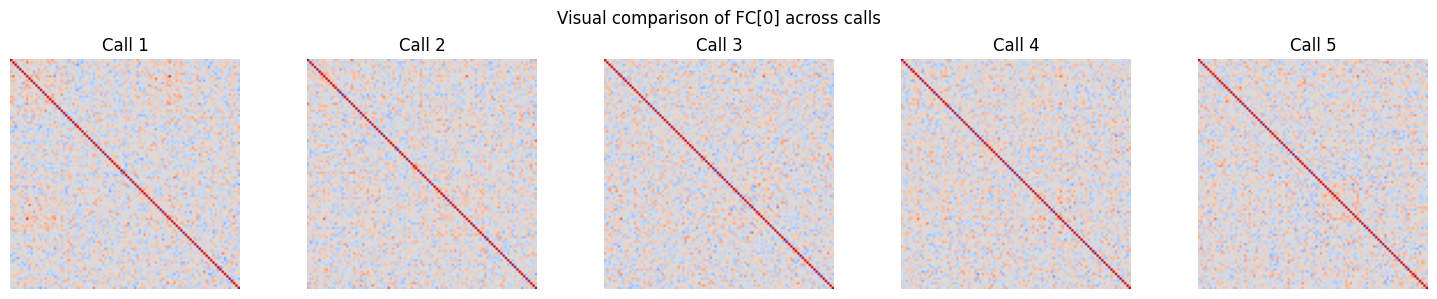

In [11]:
import torch
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def flatten_upper_tri(fc_tensor):
    """Return upper triangle as 1D vector (excluding diagonal)"""
    n = fc_tensor.shape[-1]
    idx = torch.triu_indices(n, n, offset=1)
    return fc_tensor[:, idx[0], idx[1]]  # shape: (B, N*(N-1)//2)

def test_get_simulated_batch_variability(sim, chunk=200, n_rep=2, B=5, num_calls=5):
    print("Testing variability across multiple calls to get_simulated_batch()...\n")

    fc_batches = []
    for i in range(num_calls):
        fc = get_simulated_batch(sim, chunk, n_rep=n_rep, B=B).detach().cpu()
        fc_batches.append(flatten_upper_tri(fc))  # shape: [B, M]
        print(f"Batch {i+1}: mean={fc.mean():.4f}, std={fc.std():.4f}")

    # Compare FC_i from batch_a with FC_i from batch_b
    for i in range(B):
        for j in range(1, num_calls):
            r, _ = pearsonr(fc_batches[0][i], fc_batches[j][i])
            print(f"FC {i+1}: Pearson(r) between call 1 and {j+1} = {r:.4f}")

    # Optional: visualize first FC across calls
    plt.figure(figsize=(15, 3))
    for i in range(num_calls):
        plt.subplot(1, num_calls, i+1)
        fc_mat = get_simulated_batch(sim, chunk, n_rep=n_rep, B=1)[0].cpu().numpy()
        plt.imshow(fc_mat, vmin=-1, vmax=1, cmap="coolwarm")
        plt.title(f"Call {i+1}")
        plt.axis('off')
    plt.suptitle("Visual comparison of FC[0] across calls")
    plt.tight_layout()
    plt.show()

test_get_simulated_batch_variability(sim, chunk=200, n_rep=5, B=5, num_calls=5)


In [12]:
def save_precomputed_fc(loader, sim, subj, chunk, batch, n_batches, out_real, out_fake):
    all_real = []
    all_fake = []

    for _ in range(n_batches):
        real = get_empirical_batch(loader, subj=subj, chunk=chunk, B=batch).cpu()
        fake = get_simulated_batch(sim, chunk=chunk, n_rep=3, B=batch).cpu()
        all_real.append(real)
        all_fake.append(fake)

    torch.save(torch.cat(all_real), out_real)
    torch.save(torch.cat(all_fake), out_fake)
    print(f"[+] Saved real to {out_real}, fake to {out_fake}")

save_precomputed_fc(loader, sim, subj=18, chunk=200, batch=16, n_batches=100, out_real='real_fc.pt', out_fake='fake_fc.pt')


[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1671522 0.54398817
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1707337 0.5482065
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1581843 0.545226
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1600795 0.5459195
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1701424 0.5446819
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1644988 0.5428094
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1583743 0.5432606
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.169326 0.54369116
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1462348 0.5461548
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.164546 0.54710805
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1669195 0.54335266
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.168693 0.54371214
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.1587615 0.5417972
[Simulator] Simulating 6 windows 
Sim TS mean/std: 2.173644 0.5462185
[Simul

In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class PrecomputedFCDataset(Dataset):
    def __init__(self, path, label):
        self.data = torch.load(path)
        self.label = torch.full((len(self.data), 1), float(label), dtype=torch.float32)

    def __len__(self): return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx].unsqueeze(0)  # (1, N, N) for Conv2D
        y = self.label[idx]
        return x, y


In [7]:

# build discriminator
disc = FCCNNDisc(sim.model.node_size).to(DEVICE)
optD = torch.optim.Adam(disc.parameters(), lr=1e-2, betas=(0.5, 0.999))
bce = torch.nn.BCELoss()

real_dataset = PrecomputedFCDataset('real_fc.pt', label=1)
fake_dataset = PrecomputedFCDataset('fake_fc.pt', label=0)

real_loader = DataLoader(real_dataset, batch_size=16, shuffle=True)
fake_loader = DataLoader(fake_dataset, batch_size=16, shuffle=True)

real_iter = iter(real_loader)
fake_iter = iter(fake_loader)


# Training loop
for ep in range(epochs_disc):
    pbar = trange(200, desc=f"Disc-epoch {ep+1}/{epochs_disc}", leave=False)
    for _ in pbar:
        # real_fc = get_empirical_batch(loader, subj, chunk, batch)
        # fake_fc = get_simulated_batch(sim, chunk, n_rep=2, B=batch)
        # fake_fc = torch.randn(batch, 100, 100, device=DEVICE)
        # show_batch_fc(real_fc.cpu().numpy(), fake_fc.cpu().numpy(), n=2)
        # y_real = torch.ones(batch, 1, device=DEVICE)
        # y_fake = torch.zeros(batch, 1, device=DEVICE)
        # with torch.no_grad():
        #     real_out = disc(real_fc).mean().item()
        #     fake_out = disc(fake_fc).mean().item()
        #     print(f"Disc out: Real={real_out:.3f}, Fake={fake_out:.3f}")
        
        try: real_fc, y_real = next(real_iter)
        except StopIteration: real_iter = iter(real_loader); real_fc, y_real = next(real_iter)
        
        try: fake_fc, y_fake = next(fake_iter)
        except StopIteration: fake_iter = iter(fake_loader); fake_fc, y_fake = next(fake_iter)

        real_fc, y_real = real_fc.to(DEVICE), y_real.to(DEVICE)
        fake_fc, y_fake = fake_fc.to(DEVICE), y_fake.to(DEVICE)

        disc.train(); optD.zero_grad()
        loss_real = bce(disc(real_fc), y_real); loss_fake = bce(disc(fake_fc), y_fake)
        print(f"[Loss] Real = {loss_real.item()}  Fake = {loss_fake.item()}")
        loss = loss_real + loss_fake
        loss.backward(); optD.step()
        pbar.set_postfix(d_loss=float(loss))
        # heatmap_fc(fake_fc[0].detach().cpu().numpy(), real_fc[0].detach().cpu().numpy(), outdir="plots", subdir="disc_train")

torch.save(disc.state_dict(), "discriminator_weights/disc_sub18.pt")
print("[+] discriminator saved → discriminator_weights/disc_sub18.pt")

# visualise_disc_output(disc, real_fc, fake_fc, subj=subj)


Disc-epoch 1/5:   0%|          | 1/200 [00:00<01:01,  3.23it/s, d_loss=1.33]

[Loss] Real = 0.7094674706459045  Fake = 0.6814013123512268
[Loss] Real = 0.6488558053970337  Fake = 0.7160831689834595
[Loss] Real = 0.6379812359809875  Fake = 0.6927589774131775
[Loss] Real = 0.5614491105079651  Fake = 0.7045221328735352


Disc-epoch 1/5:   4%|▎         | 7/200 [00:00<00:12, 15.41it/s, d_loss=0.527]

[Loss] Real = 0.43324756622314453  Fake = 0.7694501876831055
[Loss] Real = 0.5577565431594849  Fake = 0.605018138885498
[Loss] Real = 0.33020567893981934  Fake = 0.6412715911865234
[Loss] Real = 0.3242899179458618  Fake = 0.41878777742385864
[Loss] Real = 0.2067609429359436  Fake = 0.3198581039905548


Disc-epoch 1/5:   6%|▋         | 13/200 [00:00<00:09, 20.13it/s, d_loss=0.0329]

[Loss] Real = 0.1441744565963745  Fake = 0.19184885919094086
[Loss] Real = 0.03889982029795647  Fake = 0.1317894607782364
[Loss] Real = 0.05216936022043228  Fake = 0.04009976238012314
[Loss] Real = 0.014252111315727234  Fake = 0.04174426570534706
[Loss] Real = 0.00856231153011322  Fake = 0.024342738091945648


Disc-epoch 1/5:  10%|▉         | 19/200 [00:01<00:08, 22.18it/s, d_loss=0.00947]

[Loss] Real = 0.006363342050462961  Fake = 0.015278525650501251
[Loss] Real = 0.004916873760521412  Fake = 0.0081059904769063
[Loss] Real = 0.004879732616245747  Fake = 0.007311930879950523
[Loss] Real = 0.0027097933925688267  Fake = 0.0068719941191375256
[Loss] Real = 0.0030348035506904125  Fake = 0.0064320191740989685


Disc-epoch 1/5:  11%|█         | 22/200 [00:01<00:07, 22.78it/s, d_loss=0.00475]

[Loss] Real = 0.002171550877392292  Fake = 0.003577297553420067
[Loss] Real = 0.0018803293351083994  Fake = 0.0054447646252810955
[Loss] Real = 0.001476699486374855  Fake = 0.004024343099445105
[Loss] Real = 0.001252374378964305  Fake = 0.0028428516816347837
[Loss] Real = 0.002186145633459091  Fake = 0.0025629596784710884


Disc-epoch 1/5:  14%|█▍        | 28/200 [00:01<00:07, 23.50it/s, d_loss=0.00252]

[Loss] Real = 0.0016071712598204613  Fake = 0.0021642926149070263
[Loss] Real = 0.0013934638118371367  Fake = 0.0022938342299312353
[Loss] Real = 0.0007632360211573541  Fake = 0.0020601460710167885
[Loss] Real = 0.0006964053027331829  Fake = 0.002750830724835396
[Loss] Real = 0.0006530187092721462  Fake = 0.0018698751227930188


Disc-epoch 1/5:  17%|█▋        | 34/200 [00:01<00:06, 23.92it/s, d_loss=0.00148]

[Loss] Real = 0.0015625611413270235  Fake = 0.0016672112978994846
[Loss] Real = 0.0006241404335014522  Fake = 0.0019263052381575108
[Loss] Real = 0.0006279131048358977  Fake = 0.0019033373100683093
[Loss] Real = 0.000444853154476732  Fake = 0.001220080303028226
[Loss] Real = 0.0002943322469945997  Fake = 0.0011905792634934187


Disc-epoch 1/5:  18%|█▊        | 37/200 [00:01<00:06, 24.04it/s, d_loss=0.00118]

[Loss] Real = 0.00046324043069034815  Fake = 0.0013536158949136734
[Loss] Real = 0.0002888670423999429  Fake = 0.0011068492894992232
[Loss] Real = 0.0002174487744923681  Fake = 0.0007957170018926263
[Loss] Real = 0.00043156894389539957  Fake = 0.0006770078325644135
[Loss] Real = 0.0003689882578328252  Fake = 0.0008149475906975567


Disc-epoch 1/5:  22%|██▏       | 43/200 [00:02<00:06, 24.15it/s, d_loss=0.00074] 

[Loss] Real = 0.00041996140498667955  Fake = 0.0008004724513739347
[Loss] Real = 0.0002068038156721741  Fake = 0.0006867122719995677
[Loss] Real = 0.0001667825854383409  Fake = 0.0005283815553411841
[Loss] Real = 0.00035480636870488524  Fake = 0.0003798755060415715
[Loss] Real = 0.00012549845268949866  Fake = 0.000614412478171289


Disc-epoch 1/5:  24%|██▍       | 49/200 [00:02<00:06, 24.24it/s, d_loss=0.000448]

[Loss] Real = 0.00013920848141424358  Fake = 0.0004316030244808644
[Loss] Real = 0.00033641973277553916  Fake = 0.00048775679897516966
[Loss] Real = 5.330072599463165e-05  Fake = 0.00042342065717093647
[Loss] Real = 0.0002807555138133466  Fake = 0.0004713364178314805
[Loss] Real = 0.00013924078666605055  Fake = 0.000309228606056422


Disc-epoch 1/5:  26%|██▌       | 52/200 [00:02<00:06, 24.24it/s, d_loss=0.00062] 

[Loss] Real = 0.00019938565674237907  Fake = 0.0005256999866105616
[Loss] Real = 0.0008241839241236448  Fake = 0.00031592691084370017
[Loss] Real = 0.00011195518891327083  Fake = 0.0005560184363275766
[Loss] Real = 0.00015941864694468677  Fake = 0.0009005602332763374
[Loss] Real = 9.689281432656571e-05  Fake = 0.0005230521783232689


Disc-epoch 1/5:  29%|██▉       | 58/200 [00:02<00:05, 24.14it/s, d_loss=0.000303]

[Loss] Real = 7.056137837935239e-05  Fake = 0.0006878109415993094
[Loss] Real = 0.00016897225577849895  Fake = 0.0002642449690029025
[Loss] Real = 0.00010564563854131848  Fake = 0.00026193243684247136
[Loss] Real = 0.00010322507296223193  Fake = 0.0004370376409497112
[Loss] Real = 2.4147853764588945e-05  Fake = 0.00027853320352733135


Disc-epoch 1/5:  32%|███▏      | 64/200 [00:02<00:05, 24.15it/s, d_loss=0.000343]

[Loss] Real = 0.00010395220306236297  Fake = 0.00021066106273792684
[Loss] Real = 8.360639185411856e-05  Fake = 0.00016356442938558757
[Loss] Real = 0.00011619275028351694  Fake = 0.00027996860444545746
[Loss] Real = 3.139055479550734e-05  Fake = 0.0003223206731490791
[Loss] Real = 1.2442658771760762e-05  Fake = 0.0003305600839667022


Disc-epoch 1/5:  34%|███▎      | 67/200 [00:03<00:05, 24.14it/s, d_loss=0.000513]

[Loss] Real = 9.438304550712928e-05  Fake = 0.0003022553282789886
[Loss] Real = 7.255651144078001e-05  Fake = 0.0001605860161362216
[Loss] Real = 0.00016946173855103552  Fake = 0.00036431330954656005
[Loss] Real = 4.517989145824686e-05  Fake = 7.024918886600062e-05
[Loss] Real = 0.0002142507873941213  Fake = 0.0002982620499096811


Disc-epoch 1/5:  36%|███▋      | 73/200 [00:03<00:05, 24.16it/s, d_loss=0.000234]

[Loss] Real = 0.00017996142560150474  Fake = 0.0001431470736861229
[Loss] Real = 1.8485159671399742e-05  Fake = 0.00016195536591112614
[Loss] Real = 3.377494795131497e-05  Fake = 0.00013395263522397727
[Loss] Real = 4.4582011469174176e-05  Fake = 0.0003598513430915773
[Loss] Real = 7.099789218045771e-05  Fake = 0.00016345284529961646


Disc-epoch 1/5:  40%|███▉      | 79/200 [00:03<00:05, 24.12it/s, d_loss=0.000154]

[Loss] Real = 2.9386274036369286e-05  Fake = 0.00011078341776737943
[Loss] Real = 0.00020924735872540623  Fake = 0.00017311988631263375
[Loss] Real = 4.528799036052078e-05  Fake = 0.0001655935193412006
[Loss] Real = 7.817867299309e-05  Fake = 0.00014639034634456038
[Loss] Real = 1.522201819170732e-05  Fake = 0.00013909765402786434


Disc-epoch 1/5:  41%|████      | 82/200 [00:03<00:04, 24.12it/s, d_loss=9.87e-5] 

[Loss] Real = 6.327575101749972e-05  Fake = 0.00015876135148573667
[Loss] Real = 3.804880179814063e-05  Fake = 0.00014289849787019193
[Loss] Real = 0.0002051560877589509  Fake = 0.0001409000251442194
[Loss] Real = 4.0873004763852805e-05  Fake = 0.00015519923181273043
[Loss] Real = 4.901360080111772e-05  Fake = 4.9715497880242765e-05


Disc-epoch 1/5:  44%|████▍     | 88/200 [00:03<00:04, 24.18it/s, d_loss=0.000238]

[Loss] Real = 2.0676499843830243e-05  Fake = 0.0001963429240277037
[Loss] Real = 2.7319314540363848e-05  Fake = 0.00013689196202903986
[Loss] Real = 1.901480572996661e-05  Fake = 0.00015207601245492697
[Loss] Real = 6.809906153648626e-06  Fake = 0.000124612997751683
[Loss] Real = 0.00013367441715672612  Fake = 0.00010439637117087841


Disc-epoch 1/5:  47%|████▋     | 94/200 [00:04<00:04, 24.18it/s, d_loss=0.000102]

[Loss] Real = 4.7711917432025075e-05  Fake = 3.129521428490989e-05
[Loss] Real = 1.1086805898230523e-05  Fake = 0.00010815200221259147
[Loss] Real = 4.6488097723340616e-05  Fake = 0.00017960453988052905
[Loss] Real = 8.133711526170373e-05  Fake = 0.000156195746967569
[Loss] Real = 1.4573828593711369e-05  Fake = 8.75555124366656e-05


Disc-epoch 1/5:  48%|████▊     | 97/200 [00:04<00:04, 24.18it/s, d_loss=0.0002]  

[Loss] Real = 0.0001434860605513677  Fake = 9.371000487590209e-05
[Loss] Real = 2.0404851966304705e-05  Fake = 6.544357165694237e-05
[Loss] Real = 2.3850447178119794e-05  Fake = 8.188914944184944e-05
[Loss] Real = 8.314948900078889e-06  Fake = 7.109655416570604e-05
[Loss] Real = 5.286879604682326e-05  Fake = 0.0001475806493544951


Disc-epoch 1/5:  52%|█████▏    | 103/200 [00:04<00:04, 24.20it/s, d_loss=0.000108]

[Loss] Real = 0.00019068337860517204  Fake = 0.0002506774908397347
[Loss] Real = 1.478273952670861e-05  Fake = 0.0001239925331901759
[Loss] Real = 1.5363575585070066e-05  Fake = 0.0001323106698691845
[Loss] Real = 1.151132437371416e-05  Fake = 7.809014641679823e-05
[Loss] Real = 3.685978299472481e-05  Fake = 7.158765220083296e-05


Disc-epoch 1/5:  55%|█████▍    | 109/200 [00:04<00:03, 24.27it/s, d_loss=0.000168]

[Loss] Real = 1.4991246644058265e-05  Fake = 0.00016997434431686997
[Loss] Real = 7.906148675829172e-05  Fake = 0.00013539222709368914
[Loss] Real = 7.517720860050758e-06  Fake = 0.00013225089060142636
[Loss] Real = 1.3038754332228564e-05  Fake = 8.613272075308487e-05
[Loss] Real = 0.00012375811638776213  Fake = 4.458237890503369e-05


Disc-epoch 1/5:  56%|█████▌    | 112/200 [00:04<00:03, 24.30it/s, d_loss=0.00217] 

[Loss] Real = 0.0004481135110836476  Fake = 0.00010599485540296882
[Loss] Real = 2.1000931155867875e-05  Fake = 7.112881576176733e-05
[Loss] Real = 7.227159585454501e-06  Fake = 4.618433376890607e-05
[Loss] Real = 0.00013140513328835368  Fake = 7.122373062884435e-05
[Loss] Real = 0.0020120993722230196  Fake = 0.00015665651881136


Disc-epoch 1/5:  59%|█████▉    | 118/200 [00:05<00:03, 24.29it/s, d_loss=0.00031] 

[Loss] Real = 2.5683581043267623e-05  Fake = 0.000125747115816921
[Loss] Real = 0.0008367079426534474  Fake = 0.0003078601148445159
[Loss] Real = 2.314723860763479e-05  Fake = 0.00102244783192873
[Loss] Real = 4.4206179154571146e-05  Fake = 0.00037633563624694943
[Loss] Real = 1.6928337572608143e-05  Fake = 0.00029344853828661144


Disc-epoch 1/5:  62%|██████▏   | 124/200 [00:05<00:03, 24.34it/s, d_loss=0.000102]

[Loss] Real = 2.3668131689191796e-05  Fake = 0.00014780824130866677
[Loss] Real = 1.8478282072464935e-05  Fake = 0.000466823170427233
[Loss] Real = 1.2986763067601714e-05  Fake = 0.00019201198301743716
[Loss] Real = 3.687197022372857e-05  Fake = 9.171389683615416e-05
[Loss] Real = 5.441659959615208e-05  Fake = 4.7676890972070396e-05


Disc-epoch 1/5:  64%|██████▎   | 127/200 [00:05<00:02, 24.33it/s, d_loss=0.000116]

[Loss] Real = 6.166918319649994e-05  Fake = 0.00020432096789591014
[Loss] Real = 3.532727714627981e-05  Fake = 0.00018582171469461173
[Loss] Real = 9.121187031269073e-05  Fake = 7.445049413945526e-05
[Loss] Real = 1.691365469014272e-05  Fake = 0.00011721092596417293
[Loss] Real = 4.808496669284068e-05  Fake = 6.807097815908492e-05


Disc-epoch 1/5:  66%|██████▋   | 133/200 [00:05<00:02, 24.38it/s, d_loss=0.000143]

[Loss] Real = 3.958768866141327e-05  Fake = 5.513148062163964e-05
[Loss] Real = 1.248742137249792e-05  Fake = 9.322287223767489e-05
[Loss] Real = 2.6865101972362027e-05  Fake = 0.00021336329518817365
[Loss] Real = 1.2353399142739363e-05  Fake = 0.00012468104250729084
[Loss] Real = 6.586435119970702e-06  Fake = 0.00013597292127087712


Disc-epoch 1/5:  70%|██████▉   | 139/200 [00:06<00:02, 24.38it/s, d_loss=0.000145]

[Loss] Real = 5.9679499827325344e-05  Fake = 9.846947068581358e-05
[Loss] Real = 5.092866194900125e-05  Fake = 0.00011515867663547397
[Loss] Real = 2.3996753952815197e-05  Fake = 9.359708201372996e-05
[Loss] Real = 1.3381863027461804e-05  Fake = 0.00022999958309810609
[Loss] Real = 1.937160504894564e-06  Fake = 0.0001432575227227062


Disc-epoch 1/5:  71%|███████   | 142/200 [00:06<00:02, 24.38it/s, d_loss=6.8e-5]  

[Loss] Real = 4.013959187432192e-05  Fake = 0.00014339361223392189
[Loss] Real = 2.4995661078719422e-05  Fake = 5.8145269576925784e-05
[Loss] Real = 1.90040282177506e-05  Fake = 7.835676660761237e-05
[Loss] Real = 2.7939768187934533e-06  Fake = 0.00010509547428227961
[Loss] Real = 1.6202371625695378e-05  Fake = 5.176792910788208e-05


Disc-epoch 1/5:  74%|███████▍  | 148/200 [00:06<00:02, 24.36it/s, d_loss=5.27e-5] 

[Loss] Real = 8.042623085202649e-05  Fake = 7.04889971530065e-05
[Loss] Real = 4.470458407013211e-06  Fake = 5.475389116327278e-05
[Loss] Real = 8.501291631546337e-06  Fake = 0.0001311312516918406
[Loss] Real = 6.64569524815306e-05  Fake = 0.00011270347749814391
[Loss] Real = 1.3508570191334002e-05  Fake = 3.917259891750291e-05


Disc-epoch 1/5:  77%|███████▋  | 154/200 [00:06<00:01, 24.23it/s, d_loss=8.37e-5] 

[Loss] Real = 3.347083111293614e-05  Fake = 7.987506251083687e-05
[Loss] Real = 1.766288187354803e-05  Fake = 6.82565150782466e-05
[Loss] Real = 2.793975227177725e-06  Fake = 0.00013889728870708495
[Loss] Real = 2.226823016826529e-05  Fake = 7.370080857072026e-05
[Loss] Real = 7.607163752254564e-06  Fake = 7.605052087455988e-05


Disc-epoch 1/5:  78%|███████▊  | 157/200 [00:06<00:01, 24.17it/s, d_loss=8.72e-5] 

[Loss] Real = 4.875993909081444e-05  Fake = 5.89761693845503e-05
[Loss] Real = 1.5944285678415326e-06  Fake = 2.6386787794763222e-05
[Loss] Real = 7.26926009519957e-05  Fake = 6.729512824676931e-05
[Loss] Real = 6.310725893854396e-06  Fake = 3.303953417344019e-05
[Loss] Real = 5.424178652901901e-06  Fake = 8.176933624781668e-05


Disc-epoch 1/5:  82%|████████▏ | 163/200 [00:07<00:01, 24.12it/s, d_loss=6.11e-5]

[Loss] Real = 3.599870251491666e-05  Fake = 5.826609776704572e-05
[Loss] Real = 1.6123514797072858e-05  Fake = 3.156126331305131e-05
[Loss] Real = 5.3468000260181725e-05  Fake = 4.696495670941658e-05
[Loss] Real = 3.7849627005925868e-06  Fake = 3.553597707650624e-05
[Loss] Real = 7.383627234958112e-06  Fake = 5.367479025153443e-05


Disc-epoch 1/5:  84%|████████▍ | 169/200 [00:07<00:01, 24.09it/s, d_loss=5.51e-5] 

[Loss] Real = 1.261421220988268e-05  Fake = 9.002289152704179e-05
[Loss] Real = 2.633962685649749e-05  Fake = 4.882232678937726e-05
[Loss] Real = 3.625022145570256e-05  Fake = 0.00010548820137046278
[Loss] Real = 1.803595841920469e-05  Fake = 6.0603928432101384e-05
[Loss] Real = 2.0181183572276495e-05  Fake = 3.495148484944366e-05


Disc-epoch 1/5:  86%|████████▌ | 172/200 [00:07<00:01, 24.11it/s, d_loss=2.92e-5] 

[Loss] Real = 1.848574902396649e-05  Fake = 7.19349118298851e-05
[Loss] Real = 2.2984064344200306e-05  Fake = 8.889769378583878e-05
[Loss] Real = 2.4438140826532617e-06  Fake = 4.5397100620903075e-05
[Loss] Real = 4.95469475936261e-06  Fake = 0.0001346556528005749
[Loss] Real = 4.045691184728639e-06  Fake = 2.517339635232929e-05


Disc-epoch 1/5:  89%|████████▉ | 178/200 [00:07<00:00, 24.21it/s, d_loss=0.00012] 

[Loss] Real = 4.872746103501413e-06  Fake = 0.0001394069695379585
[Loss] Real = 1.9022614651476033e-05  Fake = 3.430179276620038e-05
[Loss] Real = 5.744519512518309e-06  Fake = 3.092384577030316e-05
[Loss] Real = 6.096263314248063e-05  Fake = 8.053873898461461e-05
[Loss] Real = 3.643378477136139e-06  Fake = 0.00011630208609858528


Disc-epoch 1/5:  92%|█████████▏| 184/200 [00:07<00:00, 24.25it/s, d_loss=6.09e-5] 

[Loss] Real = 3.2261182241200004e-06  Fake = 7.616078801220283e-05
[Loss] Real = 0.00017240959277842194  Fake = 6.042365566827357e-05
[Loss] Real = 2.3841969323257217e-06  Fake = 5.8810259361052886e-05
[Loss] Real = 1.2770757166435942e-05  Fake = 6.808188481954858e-05
[Loss] Real = 8.151123438437935e-06  Fake = 5.272454291116446e-05


Disc-epoch 1/5:  94%|█████████▎| 187/200 [00:08<00:00, 24.19it/s, d_loss=0.000144]

[Loss] Real = 7.301938694581622e-06  Fake = 1.6753399904700927e-05
[Loss] Real = 5.863700607733335e-06  Fake = 3.2130246836459264e-05
[Loss] Real = 4.045723017043201e-06  Fake = 9.456990665057674e-05
[Loss] Real = 2.5034059945028275e-06  Fake = 4.761299351230264e-05
[Loss] Real = 3.671500235213898e-05  Fake = 0.00010733735689427704


Disc-epoch 1/5:  96%|█████████▋| 193/200 [00:08<00:00, 24.06it/s, d_loss=6.37e-5] 

[Loss] Real = 1.8438182451063767e-05  Fake = 1.9582354070735164e-05
[Loss] Real = 7.763665962556843e-06  Fake = 6.0947735619265586e-05
[Loss] Real = 6.109485752858745e-07  Fake = 3.3440952392993495e-05
[Loss] Real = 1.075183718057815e-05  Fake = 1.432405406376347e-05
[Loss] Real = 5.34959963260917e-06  Fake = 5.838444849359803e-05


Disc-epoch 1/5: 100%|█████████▉| 199/200 [00:08<00:00, 24.02it/s, d_loss=0.000103]

[Loss] Real = 8.717412129044533e-06  Fake = 2.0553317881422117e-05
[Loss] Real = 1.4052670849196147e-05  Fake = 3.367366298334673e-05
[Loss] Real = 1.4454163874688675e-06  Fake = 4.5446973672369495e-05
[Loss] Real = 1.1548415841389215e-06  Fake = 6.94484479026869e-05
[Loss] Real = 8.987351611722261e-05  Fake = 1.2966267604497261e-05


[Loss] Real = 2.667339003892266e-06  Fake = 8.710590191185474e-05


Disc-epoch 2/5:   2%|▏         | 3/200 [00:00<00:08, 24.23it/s, d_loss=3.6e-5] 

[Loss] Real = 1.7806969481171109e-06  Fake = 1.7606722394702956e-05
[Loss] Real = 1.1705245924531482e-05  Fake = 2.9780087061226368e-05
[Loss] Real = 4.433129561220994e-06  Fake = 4.3040141463279724e-05
[Loss] Real = 1.8477508092473727e-06  Fake = 3.418594496906735e-05


Disc-epoch 2/5:   2%|▏         | 3/200 [00:00<00:08, 24.23it/s, d_loss=4.16e-5]

[Loss] Real = 1.3445910553855356e-05  Fake = 2.8168418793939054e-05


Disc-epoch 2/5:   4%|▍         | 9/200 [00:00<00:07, 24.12it/s, d_loss=3.96e-5] 

[Loss] Real = 7.801157153153326e-06  Fake = 0.00012904158211313188
[Loss] Real = 1.1720276233972982e-05  Fake = 4.8118297854671255e-05
[Loss] Real = 3.762616870517377e-06  Fake = 2.0047691577929072e-05
[Loss] Real = 2.726925686147297e-06  Fake = 3.682439273688942e-05


Disc-epoch 2/5:   4%|▍         | 9/200 [00:00<00:07, 24.12it/s, d_loss=0.000144]

[Loss] Real = 6.91426030243747e-05  Fake = 7.448070391546935e-05


Disc-epoch 2/5:   6%|▌         | 12/200 [00:00<00:07, 24.07it/s, d_loss=4.49e-5]

[Loss] Real = 1.2137681551394053e-05  Fake = 3.793137875618413e-05
[Loss] Real = 2.3171592147264164e-06  Fake = 2.8256014047656208e-05
[Loss] Real = 2.9579055080830585e-06  Fake = 2.3897673600004055e-05
[Loss] Real = 1.1473941867734538e-06  Fake = 4.3714557250496e-05


Disc-epoch 2/5:   8%|▊         | 15/200 [00:00<00:07, 24.08it/s, d_loss=3.37e-5]

[Loss] Real = 1.0975161785609089e-05  Fake = 2.2719477783539332e-05


Disc-epoch 2/5:   9%|▉         | 18/200 [00:00<00:07, 24.05it/s, d_loss=7.15e-5]

[Loss] Real = 1.0430837846797658e-06  Fake = 6.131938425824046e-05
[Loss] Real = 2.5817715140874498e-05  Fake = 1.9670536858029664e-05
[Loss] Real = 3.174004859829438e-06  Fake = 1.5695957699790597e-05
[Loss] Real = 4.3320680561009794e-05  Fake = 2.818043685692828e-05


Disc-epoch 2/5:   9%|▉         | 18/200 [00:00<00:07, 24.05it/s, d_loss=2.35e-5]

[Loss] Real = 6.728029347868869e-06  Fake = 1.6767342458479106e-05


Disc-epoch 2/5:  12%|█▏        | 24/200 [00:00<00:07, 24.01it/s, d_loss=0.000104]

[Loss] Real = 2.0999012122047134e-05  Fake = 3.1877425499260426e-05
[Loss] Real = 3.755138550332049e-06  Fake = 4.1742267057998106e-05
[Loss] Real = 1.9585369955166243e-05  Fake = 3.2291925890604034e-05
[Loss] Real = 2.928108187916223e-06  Fake = 0.00010117593046743423


Disc-epoch 2/5:  12%|█▏        | 24/200 [00:01<00:07, 24.01it/s, d_loss=7.78e-5] 

[Loss] Real = 3.370067133801058e-05  Fake = 4.405314030009322e-05


Disc-epoch 2/5:  14%|█▎        | 27/200 [00:01<00:07, 24.16it/s, d_loss=2.57e-5]

[Loss] Real = 3.1292663607018767e-06  Fake = 6.607593240914866e-05
[Loss] Real = 6.556659172929358e-06  Fake = 4.6672892494825646e-05
[Loss] Real = 6.7726427914749365e-06  Fake = 2.5497203751001507e-05
[Loss] Real = 4.693870607752615e-07  Fake = 2.5272101993323304e-05


Disc-epoch 2/5:  15%|█▌        | 30/200 [00:01<00:07, 24.28it/s, d_loss=2.46e-5]

[Loss] Real = 1.7583415683475323e-06  Fake = 2.2839245502837002e-05


Disc-epoch 2/5:  16%|█▋        | 33/200 [00:01<00:06, 24.38it/s, d_loss=1.38e-5]

[Loss] Real = 2.980248609674163e-06  Fake = 2.9874725441914052e-05
[Loss] Real = 3.099479727097787e-06  Fake = 3.514545096550137e-05
[Loss] Real = 2.8833915166615043e-06  Fake = 2.230626341770403e-05
[Loss] Real = 1.2442542356438935e-06  Fake = 1.257045914826449e-05


Disc-epoch 2/5:  16%|█▋        | 33/200 [00:01<00:06, 24.38it/s, d_loss=6.07e-5]

[Loss] Real = 3.921027746400796e-05  Fake = 2.1476971596712247e-05


Disc-epoch 2/5:  20%|█▉        | 39/200 [00:01<00:06, 24.48it/s, d_loss=8.08e-5]

[Loss] Real = 2.5183164780173684e-06  Fake = 5.6871453125495464e-05
[Loss] Real = 2.033852433669381e-05  Fake = 2.85812966467347e-05
[Loss] Real = 1.631786290090531e-05  Fake = 1.2696104931819718e-05
[Loss] Real = 3.898609793395735e-05  Fake = 4.183228884357959e-05


Disc-epoch 2/5:  20%|█▉        | 39/200 [00:01<00:06, 24.48it/s, d_loss=3.99e-5]

[Loss] Real = 1.4253551853471436e-05  Fake = 2.5659173843450844e-05


Disc-epoch 2/5:  21%|██        | 42/200 [00:01<00:06, 24.48it/s, d_loss=9.07e-5]

[Loss] Real = 3.594406007323414e-05  Fake = 3.108831515419297e-05
[Loss] Real = 5.707211585104233e-06  Fake = 8.582685950386804e-06
[Loss] Real = 2.525765012251213e-06  Fake = 4.2602550820447505e-05
[Loss] Real = 6.638826744165272e-05  Fake = 2.4313210815307684e-05


Disc-epoch 2/5:  22%|██▎       | 45/200 [00:01<00:06, 24.51it/s, d_loss=4.65e-5]

[Loss] Real = 3.826416650554165e-05  Fake = 8.250172868429217e-06


Disc-epoch 2/5:  24%|██▍       | 48/200 [00:02<00:06, 24.51it/s, d_loss=2.57e-5]

[Loss] Real = 1.19209801141551e-06  Fake = 2.130701977876015e-05
[Loss] Real = 1.2040690307912882e-05  Fake = 4.52013555332087e-05
[Loss] Real = 1.750900196384464e-06  Fake = 5.7739176554605365e-05
[Loss] Real = 2.0191171188344015e-06  Fake = 2.3681301172473468e-05


Disc-epoch 2/5:  24%|██▍       | 48/200 [00:02<00:06, 24.51it/s, d_loss=2.6e-5] 

[Loss] Real = 1.3113046861690236e-06  Fake = 2.470904655638151e-05


Disc-epoch 2/5:  27%|██▋       | 54/200 [00:02<00:05, 24.37it/s, d_loss=2.75e-5]

[Loss] Real = 5.140183930052444e-05  Fake = 3.619537892518565e-05
[Loss] Real = 3.688081960717682e-06  Fake = 1.225885898747947e-05
[Loss] Real = 2.853609203157248e-06  Fake = 8.687633089721203e-05
[Loss] Real = 1.8999073745362693e-06  Fake = 2.5550501959514804e-05


Disc-epoch 2/5:  27%|██▋       | 54/200 [00:02<00:05, 24.37it/s, d_loss=2.76e-5]

[Loss] Real = 2.197932417402626e-06  Fake = 2.5408953661099076e-05


Disc-epoch 2/5:  28%|██▊       | 57/200 [00:02<00:05, 24.33it/s, d_loss=4.3e-5] 

[Loss] Real = 2.039839091594331e-05  Fake = 2.3583452275488526e-05
[Loss] Real = 6.40750840830151e-07  Fake = 5.470724863698706e-05
[Loss] Real = 2.8163408387626987e-06  Fake = 3.0152003091643564e-05
[Loss] Real = 1.0803368013512227e-06  Fake = 4.192792039248161e-05


Disc-epoch 2/5:  30%|███       | 60/200 [00:02<00:05, 24.27it/s, d_loss=2.16e-5]

[Loss] Real = 8.114125193969812e-06  Fake = 1.3458002285915427e-05


Disc-epoch 2/5:  32%|███▏      | 63/200 [00:02<00:05, 24.22it/s, d_loss=8.54e-6]

[Loss] Real = 1.466031426389236e-05  Fake = 2.261923873447813e-05
[Loss] Real = 5.796703590021934e-06  Fake = 5.000701276003383e-05
[Loss] Real = 1.7509069039078895e-06  Fake = 5.715755105484277e-05
[Loss] Real = 4.3213398726038577e-07  Fake = 8.109092959784903e-06


Disc-epoch 2/5:  32%|███▏      | 63/200 [00:02<00:05, 24.22it/s, d_loss=3.29e-5]

[Loss] Real = 1.4235559319786262e-05  Fake = 1.864944351837039e-05


Disc-epoch 2/5:  34%|███▍      | 69/200 [00:02<00:05, 24.16it/s, d_loss=1.78e-5]

[Loss] Real = 2.38419852394145e-06  Fake = 2.3852710000937805e-05
[Loss] Real = 4.768374992636382e-07  Fake = 7.360342351603322e-06
[Loss] Real = 2.004213911277475e-06  Fake = 1.7506217773188837e-05
[Loss] Real = 1.1303201972623356e-05  Fake = 6.466736067523016e-06


Disc-epoch 2/5:  34%|███▍      | 69/200 [00:02<00:05, 24.16it/s, d_loss=3.81e-5]

[Loss] Real = 6.258494522626279e-07  Fake = 3.746643051272258e-05


Disc-epoch 2/5:  36%|███▌      | 72/200 [00:03<00:05, 24.15it/s, d_loss=7.37e-5]

[Loss] Real = 4.015924787381664e-06  Fake = 3.638460111687891e-05
[Loss] Real = 1.229349322784401e-06  Fake = 2.6001340302173048e-05
[Loss] Real = 7.0856467573321424e-06  Fake = 3.1784809834789485e-05
[Loss] Real = 1.4156105976326216e-07  Fake = 7.356299465755001e-05


Disc-epoch 2/5:  38%|███▊      | 75/200 [00:03<00:05, 24.12it/s, d_loss=3.47e-5]

[Loss] Real = 2.9057287065370474e-07  Fake = 3.440361615503207e-05


Disc-epoch 2/5:  39%|███▉      | 78/200 [00:03<00:05, 24.09it/s, d_loss=1.75e-5]

[Loss] Real = 1.2144520269430359e-06  Fake = 1.9304452507640235e-05
[Loss] Real = 4.91005448566284e-06  Fake = 1.350712227576878e-05
[Loss] Real = 4.855305451201275e-05  Fake = 3.582768840715289e-05
[Loss] Real = 7.599605851282831e-07  Fake = 1.6745078028179705e-05


Disc-epoch 2/5:  39%|███▉      | 78/200 [00:03<00:05, 24.09it/s, d_loss=2.89e-5]

[Loss] Real = 6.415210009436123e-06  Fake = 2.2471129341283813e-05


Disc-epoch 2/5:  42%|████▏     | 84/200 [00:03<00:04, 24.23it/s, d_loss=4.44e-5]

[Loss] Real = 7.085772722348338e-06  Fake = 2.487005986040458e-05
[Loss] Real = 3.8743047525713337e-07  Fake = 2.846511415555142e-05
[Loss] Real = 3.062225914618466e-06  Fake = 3.4570464777061716e-05
[Loss] Real = 4.187293143331772e-06  Fake = 4.02532605221495e-05


Disc-epoch 2/5:  42%|████▏     | 84/200 [00:03<00:04, 24.23it/s, d_loss=1.78e-5]

[Loss] Real = 1.0952416005238774e-06  Fake = 1.6745847460697405e-05


Disc-epoch 2/5:  44%|████▎     | 87/200 [00:03<00:04, 24.27it/s, d_loss=0.00022]

[Loss] Real = 1.5869776461840956e-06  Fake = 2.2922429707250558e-05
[Loss] Real = 6.109489731898066e-07  Fake = 2.1591184122371487e-05
[Loss] Real = 4.559821263683261e-06  Fake = 2.3126220185076818e-05
[Loss] Real = 0.00020608384511433542  Fake = 1.3713228327105753e-05


Disc-epoch 2/5:  45%|████▌     | 90/200 [00:03<00:04, 24.33it/s, d_loss=3.68e-5]

[Loss] Real = 2.7641845008474775e-06  Fake = 3.4043012419715524e-05


Disc-epoch 2/5:  46%|████▋     | 93/200 [00:03<00:04, 24.34it/s, d_loss=2.57e-5]

[Loss] Real = 7.674115067857201e-07  Fake = 6.735846545780078e-05
[Loss] Real = 1.9595224785007304e-06  Fake = 4.458289913600311e-05
[Loss] Real = 5.14090913839027e-07  Fake = 9.408746336703189e-06
[Loss] Real = 1.5103198165888898e-05  Fake = 1.0552898856985848e-05


Disc-epoch 2/5:  46%|████▋     | 93/200 [00:03<00:04, 24.34it/s, d_loss=5.76e-5]

[Loss] Real = 7.823118153282849e-07  Fake = 5.6831020629033446e-05


Disc-epoch 2/5:  50%|████▉     | 99/200 [00:04<00:04, 24.37it/s, d_loss=5.64e-5]

[Loss] Real = 1.4399581232282799e-05  Fake = 1.6348145436495543e-05
[Loss] Real = 5.528395377041306e-06  Fake = 2.7279181722406065e-06
[Loss] Real = 2.3245997908816207e-06  Fake = 1.0302763257641345e-05
[Loss] Real = 2.577930445113452e-06  Fake = 5.377700290409848e-05


Disc-epoch 2/5:  50%|████▉     | 99/200 [00:04<00:04, 24.37it/s, d_loss=6.26e-5]

[Loss] Real = 5.200265150051564e-05  Fake = 1.0626095900079235e-05


Disc-epoch 2/5:  51%|█████     | 102/200 [00:04<00:04, 24.35it/s, d_loss=1.53e-5]

[Loss] Real = 2.96534722110664e-06  Fake = 6.610840500798076e-06
[Loss] Real = 2.8522801585495472e-05  Fake = 2.8578479032148607e-05
[Loss] Real = 2.1159953575988766e-06  Fake = 1.1230591553612612e-05
[Loss] Real = 1.2964048892172286e-06  Fake = 1.4028041732672136e-05


Disc-epoch 2/5:  52%|█████▎    | 105/200 [00:04<00:03, 24.36it/s, d_loss=3.3e-5] 

[Loss] Real = 4.418236130732112e-06  Fake = 2.8553517040563747e-05


Disc-epoch 2/5:  54%|█████▍    | 108/200 [00:04<00:03, 24.37it/s, d_loss=1.92e-5]

[Loss] Real = 3.88925536753959e-06  Fake = 3.824743544100784e-05
[Loss] Real = 6.929047913217801e-07  Fake = 1.712732046144083e-05
[Loss] Real = 3.509698581183329e-05  Fake = 1.4185756299411878e-05
[Loss] Real = 2.0340139599284157e-06  Fake = 1.7198412024299614e-05


Disc-epoch 2/5:  54%|█████▍    | 108/200 [00:04<00:03, 24.37it/s, d_loss=4.72e-5]

[Loss] Real = 1.028183874041133e-06  Fake = 4.6158987970557064e-05


Disc-epoch 2/5:  57%|█████▋    | 114/200 [00:04<00:03, 24.32it/s, d_loss=3.39e-5]

[Loss] Real = 1.8784183339448646e-05  Fake = 2.9659184292540886e-05
[Loss] Real = 2.7037342078983784e-05  Fake = 1.0745170584414154e-05
[Loss] Real = 5.364429398468928e-07  Fake = 5.252152914181352e-05
[Loss] Real = 5.28991961346037e-07  Fake = 3.3348311262670904e-05


Disc-epoch 2/5:  57%|█████▋    | 114/200 [00:04<00:03, 24.32it/s, d_loss=2.09e-5]

[Loss] Real = 2.324610704818042e-06  Fake = 1.862483986769803e-05


Disc-epoch 2/5:  58%|█████▊    | 117/200 [00:04<00:03, 24.32it/s, d_loss=2.31e-5]

[Loss] Real = 1.475220642532804e-06  Fake = 1.5167390301940031e-05
[Loss] Real = 5.0962967179657426e-06  Fake = 6.66167979943566e-05
[Loss] Real = 7.972141702339286e-07  Fake = 2.203010990342591e-05
[Loss] Real = 1.2219038580951747e-06  Fake = 2.1844676666660234e-05


Disc-epoch 2/5:  60%|██████    | 120/200 [00:04<00:03, 24.34it/s, d_loss=1.39e-5]

[Loss] Real = 1.601879716872645e-06  Fake = 1.2280775081308093e-05


Disc-epoch 2/5:  62%|██████▏   | 123/200 [00:05<00:03, 24.36it/s, d_loss=4.49e-5]

[Loss] Real = 1.8477584262655e-06  Fake = 4.621193511411548e-06
[Loss] Real = 2.533198539822479e-07  Fake = 1.8155867564928485e-06
[Loss] Real = 2.242637947347248e-06  Fake = 1.4814080714131705e-05
[Loss] Real = 4.813184204977006e-06  Fake = 4.00917706429027e-05


Disc-epoch 2/5:  62%|██████▏   | 123/200 [00:05<00:03, 24.36it/s, d_loss=4.45e-5]

[Loss] Real = 8.493684617860708e-07  Fake = 4.36159098171629e-05


Disc-epoch 2/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.38it/s, d_loss=8.54e-6]

[Loss] Real = 4.0543731302022934e-05  Fake = 3.0506280381814577e-05
[Loss] Real = 7.294323950191028e-06  Fake = 7.940740761114284e-05
[Loss] Real = 1.683837808741373e-06  Fake = 5.3936724725645036e-05
[Loss] Real = 1.3113060504110763e-06  Fake = 7.226071829791181e-06


Disc-epoch 2/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.38it/s, d_loss=4.69e-5]

[Loss] Real = 6.929053597559687e-07  Fake = 4.6158587792888284e-05


Disc-epoch 2/5:  66%|██████▌   | 132/200 [00:05<00:02, 24.39it/s, d_loss=2.74e-5]

[Loss] Real = 3.2261223168461584e-06  Fake = 5.1721099225687794e-06
[Loss] Real = 2.2053875454730587e-06  Fake = 1.2172395145171322e-05
[Loss] Real = 1.8179496237280546e-06  Fake = 1.940650872711558e-05
[Loss] Real = 8.076813173829578e-06  Fake = 1.9311588403070346e-05


Disc-epoch 2/5:  68%|██████▊   | 135/200 [00:05<00:02, 24.36it/s, d_loss=3.46e-5]

[Loss] Real = 5.148493528395193e-06  Fake = 2.9424110834952444e-05


Disc-epoch 2/5:  69%|██████▉   | 138/200 [00:05<00:02, 24.33it/s, d_loss=1.96e-5]

[Loss] Real = 1.3296723409439437e-05  Fake = 2.155549736926332e-05
[Loss] Real = 3.4828703064704314e-05  Fake = 1.1553411241038702e-05
[Loss] Real = 8.456749128527008e-06  Fake = 6.547731572936755e-06
[Loss] Real = 1.6987380604405189e-06  Fake = 1.7949512766790576e-05


Disc-epoch 2/5:  69%|██████▉   | 138/200 [00:05<00:02, 24.33it/s, d_loss=1.28e-5]

[Loss] Real = 1.0430850352349808e-06  Fake = 1.1739998626580928e-05


Disc-epoch 2/5:  72%|███████▏  | 144/200 [00:05<00:02, 24.23it/s, d_loss=5.37e-5]

[Loss] Real = 4.321341293689329e-07  Fake = 5.4645261116093025e-06
[Loss] Real = 2.1557632862823084e-05  Fake = 1.324406639469089e-05
[Loss] Real = 6.183996674735681e-07  Fake = 1.2913349564769305e-05
[Loss] Real = 2.883392426156206e-06  Fake = 5.082591451355256e-05


Disc-epoch 2/5:  72%|███████▏  | 144/200 [00:05<00:02, 24.23it/s, d_loss=2.04e-5]

[Loss] Real = 4.76837954010989e-07  Fake = 1.9946526663261466e-05


Disc-epoch 2/5:  74%|███████▎  | 147/200 [00:06<00:02, 24.17it/s, d_loss=3.09e-5]

[Loss] Real = 1.117592887567298e-06  Fake = 3.7043158954475075e-05
[Loss] Real = 7.972137723299966e-07  Fake = 8.044356036407407e-06
[Loss] Real = 1.5646224937881925e-07  Fake = 1.7650068002694752e-06
[Loss] Real = 1.7359923276671907e-06  Fake = 2.9138731406419538e-05


Disc-epoch 2/5:  75%|███████▌  | 150/200 [00:06<00:02, 24.13it/s, d_loss=2.77e-5]

[Loss] Real = 2.8834044769610045e-06  Fake = 2.485414734110236e-05


Disc-epoch 2/5:  76%|███████▋  | 153/200 [00:06<00:01, 24.09it/s, d_loss=1.83e-5]

[Loss] Real = 3.926537374354666e-06  Fake = 1.6115875041577965e-05
[Loss] Real = 2.3096835377600655e-07  Fake = 4.10379288950935e-05
[Loss] Real = 1.0930775715678465e-05  Fake = 7.350737178057898e-06
[Loss] Real = 1.9744295514101395e-06  Fake = 1.637309105717577e-05


Disc-epoch 2/5:  76%|███████▋  | 153/200 [00:06<00:01, 24.09it/s, d_loss=2.19e-5]

[Loss] Real = 3.5688858588400763e-06  Fake = 1.8284572433913127e-05


Disc-epoch 2/5:  80%|███████▉  | 159/200 [00:06<00:01, 24.05it/s, d_loss=2.24e-5]

[Loss] Real = 2.533198539822479e-07  Fake = 7.2739167080726475e-06
[Loss] Real = 1.71347419382073e-05  Fake = 4.785396231454797e-05
[Loss] Real = 2.6226207410218194e-06  Fake = 1.4942686902941205e-05
[Loss] Real = 3.0994656299299095e-06  Fake = 1.9326496840221807e-05


Disc-epoch 2/5:  80%|███████▉  | 159/200 [00:06<00:01, 24.05it/s, d_loss=1.1e-5] 

[Loss] Real = 1.750907131281565e-06  Fake = 9.260869774152525e-06


Disc-epoch 2/5:  81%|████████  | 162/200 [00:06<00:01, 24.00it/s, d_loss=2.2e-5] 

[Loss] Real = 1.1473943004602916e-06  Fake = 4.307463314034976e-06
[Loss] Real = 5.476284059113823e-06  Fake = 6.371495146595407e-06
[Loss] Real = 4.068065209139604e-06  Fake = 2.71664703177521e-06
[Loss] Real = 9.745953320816625e-06  Fake = 1.2246733604115434e-05


Disc-epoch 2/5:  82%|████████▎ | 165/200 [00:06<00:01, 23.96it/s, d_loss=2.35e-5]

[Loss] Real = 7.823144869689713e-07  Fake = 2.2747513867216185e-05


Disc-epoch 2/5:  84%|████████▍ | 168/200 [00:06<00:01, 24.00it/s, d_loss=2.21e-5]

[Loss] Real = 4.619364233349188e-07  Fake = 2.9543298296630383e-05
[Loss] Real = 7.227074547699885e-07  Fake = 1.8604532669996843e-05
[Loss] Real = 4.917392857350933e-07  Fake = 2.1256400941638276e-05
[Loss] Real = 8.926175723900087e-06  Fake = 1.3167304132366553e-05


Disc-epoch 2/5:  84%|████████▍ | 168/200 [00:07<00:01, 24.00it/s, d_loss=2.23e-5]

[Loss] Real = 1.598993912921287e-05  Fake = 6.293795649980893e-06


Disc-epoch 2/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.30it/s, d_loss=2.87e-5]

[Loss] Real = 1.6540354863536777e-06  Fake = 1.236298521689605e-05
[Loss] Real = 1.2666038173847483e-06  Fake = 1.6605821656412445e-05
[Loss] Real = 3.1292509561353654e-07  Fake = 1.018866169033572e-05
[Loss] Real = 2.0861634197899548e-07  Fake = 2.8463282433222048e-05


Disc-epoch 2/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.30it/s, d_loss=0.000128]

[Loss] Real = 0.00011833896132884547  Fake = 9.472229976381641e-06


Disc-epoch 2/5:  88%|████████▊ | 177/200 [00:07<00:00, 24.38it/s, d_loss=1.58e-5] 

[Loss] Real = 3.054740318475524e-07  Fake = 5.881597098778002e-05
[Loss] Real = 1.2591528957273113e-06  Fake = 5.8549885579850525e-06
[Loss] Real = 3.09201732306974e-06  Fake = 4.386519321997184e-06
[Loss] Real = 5.312448593031149e-06  Fake = 1.0460656085342634e-05


Disc-epoch 2/5:  90%|█████████ | 180/200 [00:07<00:00, 24.44it/s, d_loss=2.19e-5]

[Loss] Real = 8.85190638655331e-06  Fake = 1.3062408470432274e-05
[Loss] Real = 6.921788553881925e-06  Fake = 3.7669411540264264e-05


Disc-epoch 2/5:  92%|█████████▏| 183/200 [00:07<00:00, 24.35it/s, d_loss=1.57e-5]

[Loss] Real = 2.0956882508471608e-05  Fake = 4.0138402255252004e-05
[Loss] Real = 4.664142579713371e-06  Fake = 7.9350857049576e-06
[Loss] Real = 8.3302420534892e-06  Fake = 7.376239864242962e-06


Disc-epoch 2/5:  93%|█████████▎| 186/200 [00:07<00:00, 24.23it/s, d_loss=9.09e-6]

[Loss] Real = 6.25851043878356e-07  Fake = 9.1169631559751e-06
[Loss] Real = 3.4943748232763028e-06  Fake = 5.597432846116135e-06


Disc-epoch 2/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.17it/s, d_loss=1.68e-5]

[Loss] Real = 1.3187641343392897e-06  Fake = 2.033549935731571e-05
[Loss] Real = 1.7359916455461644e-06  Fake = 8.059043466346338e-06
[Loss] Real = 8.099162187136244e-06  Fake = 8.72769123816397e-06


Disc-epoch 2/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.17it/s, d_loss=1.01e-5]

[Loss] Real = 1.2931441233376972e-05  Fake = 2.458585186104756e-05
[Loss] Real = 5.513447831617668e-07  Fake = 9.514252269582357e-06


Disc-epoch 2/5:  96%|█████████▌| 192/200 [00:08<00:00, 24.14it/s, d_loss=6.02e-5]

[Loss] Real = 8.940699558479537e-08  Fake = 9.734007107908837e-06
[Loss] Real = 9.909299478749745e-07  Fake = 1.417801104253158e-05
[Loss] Real = 5.364422577258665e-07  Fake = 5.965475793345831e-05


Disc-epoch 2/5:  98%|█████████▊| 195/200 [00:08<00:00, 24.11it/s, d_loss=6.28e-6]

[Loss] Real = 9.685756907629184e-08  Fake = 1.2389803487167228e-05
[Loss] Real = 3.874307878959371e-07  Fake = 5.896200491406489e-06


Disc-epoch 2/5:  99%|█████████▉| 198/200 [00:08<00:00, 24.13it/s, d_loss=2.05e-5]

[Loss] Real = 1.2584885553224012e-05  Fake = 4.313136287237285e-06
[Loss] Real = 2.980233944072097e-07  Fake = 1.5482306480407715e-05
[Loss] Real = 2.9057287065370474e-07  Fake = 2.0179209968773648e-05


[Loss] Real = 5.2677205530926585e-06  Fake = 7.47563080949476e-06


Disc-epoch 3/5:   0%|          | 0/200 [00:00<?, ?it/s, d_loss=4e-5]

[Loss] Real = 1.3929873603046872e-05  Fake = 2.60844717558939e-05


Disc-epoch 3/5:   2%|▏         | 3/200 [00:00<00:08, 24.10it/s, d_loss=7.38e-5]

[Loss] Real = 1.6912924820644548e-06  Fake = 9.842691724770702e-06
[Loss] Real = 1.0877864724534447e-06  Fake = 2.4471744836773723e-05
[Loss] Real = 8.642692250759865e-07  Fake = 7.291306974366307e-05


Disc-epoch 3/5:   2%|▏         | 3/200 [00:00<00:08, 24.10it/s, d_loss=9.96e-6]

[Loss] Real = 9.685759039257391e-08  Fake = 9.867979315458797e-06


Disc-epoch 3/5:   3%|▎         | 6/200 [00:00<00:08, 24.04it/s, d_loss=1.54e-5]

[Loss] Real = 2.831222047916526e-07  Fake = 1.5116433132789098e-05


Disc-epoch 3/5:   4%|▍         | 9/200 [00:00<00:07, 24.09it/s, d_loss=2.23e-5]

[Loss] Real = 1.2964057987119304e-06  Fake = 2.218921872554347e-05
[Loss] Real = 2.980233944072097e-07  Fake = 9.348748790216632e-06
[Loss] Real = 1.7359928961013793e-06  Fake = 2.0558152755256742e-05


Disc-epoch 3/5:   4%|▍         | 9/200 [00:00<00:07, 24.09it/s, d_loss=4.47e-5]

[Loss] Real = 1.0281837603542954e-06  Fake = 4.3709711462724954e-05


Disc-epoch 3/5:   4%|▍         | 9/200 [00:00<00:07, 24.09it/s, d_loss=8.47e-6]

[Loss] Real = 5.736958996749308e-07  Fake = 7.89831392467022e-06


Disc-epoch 3/5:   6%|▌         | 12/200 [00:00<00:07, 24.07it/s, d_loss=4.76e-6]

[Loss] Real = 3.162732537020929e-05  Fake = 1.0285048119840212e-05
[Loss] Real = 2.2798997179052094e-06  Fake = 2.2448984964285046e-05
[Loss] Real = 1.8999112398887519e-06  Fake = 2.863373538275482e-06


Disc-epoch 3/5:   8%|▊         | 15/200 [00:00<00:07, 24.05it/s, d_loss=1.23e-5]

[Loss] Real = 4.4703490686970326e-08  Fake = 1.2297939974814653e-05


Disc-epoch 3/5:   8%|▊         | 15/200 [00:00<00:07, 24.05it/s, d_loss=1.19e-5]

[Loss] Real = 1.7583507769813878e-06  Fake = 1.016837268252857e-05


Disc-epoch 3/5:   9%|▉         | 18/200 [00:00<00:07, 24.06it/s, d_loss=9.48e-6]

[Loss] Real = 1.194060496345628e-05  Fake = 9.127508747042157e-06
[Loss] Real = 7.115691914805211e-06  Fake = 7.900487617007457e-06
[Loss] Real = 9.08972879187786e-07  Fake = 8.566634278395213e-06


Disc-epoch 3/5:   9%|▉         | 18/200 [00:00<00:07, 24.06it/s, d_loss=6.81e-6]

[Loss] Real = 6.183990990393795e-07  Fake = 6.187789040268399e-06


Disc-epoch 3/5:  10%|█         | 21/200 [00:00<00:07, 24.06it/s, d_loss=1.76e-5]

[Loss] Real = 8.054306817939505e-06  Fake = 9.56121766648721e-06


Disc-epoch 3/5:  12%|█▏        | 24/200 [00:00<00:07, 24.08it/s, d_loss=8.71e-6]

[Loss] Real = 2.0678435248555616e-05  Fake = 1.1740936315618455e-05
[Loss] Real = 3.926566932932474e-06  Fake = 5.311690074449871e-06
[Loss] Real = 2.8312223321336205e-07  Fake = 8.429133231402375e-06


Disc-epoch 3/5:  12%|█▏        | 24/200 [00:01<00:07, 24.08it/s, d_loss=1.15e-5]

[Loss] Real = 2.8312243216532806e-07  Fake = 1.1233661098231096e-05


Disc-epoch 3/5:  12%|█▏        | 24/200 [00:01<00:07, 24.08it/s, d_loss=6.15e-5]

[Loss] Real = 5.470277028507553e-05  Fake = 6.776284863008186e-06


Disc-epoch 3/5:  14%|█▎        | 27/200 [00:01<00:07, 24.05it/s, d_loss=3.38e-6]

[Loss] Real = 1.7807016092774575e-06  Fake = 3.061104052903829e-06
[Loss] Real = 5.088870238978416e-06  Fake = 6.381193543347763e-06
[Loss] Real = 4.470363421660295e-07  Fake = 2.934380972874351e-06


Disc-epoch 3/5:  15%|█▌        | 30/200 [00:01<00:07, 24.08it/s, d_loss=4.71e-5]

[Loss] Real = 4.4875025196233764e-05  Fake = 2.258617541883723e-06


Disc-epoch 3/5:  15%|█▌        | 30/200 [00:01<00:07, 24.08it/s, d_loss=1.39e-5]

[Loss] Real = 8.322729627252556e-06  Fake = 5.621465334115783e-06


Disc-epoch 3/5:  16%|█▋        | 33/200 [00:01<00:06, 24.10it/s, d_loss=7.08e-5]

[Loss] Real = 3.315576805107412e-06  Fake = 1.2231656000949442e-05
[Loss] Real = 8.195652299036738e-07  Fake = 3.534308234520722e-06
[Loss] Real = 1.1057581104978453e-05  Fake = 5.969690391793847e-05


Disc-epoch 3/5:  16%|█▋        | 33/200 [00:01<00:06, 24.10it/s, d_loss=1.14e-5]

[Loss] Real = 7.3760992336247e-07  Fake = 1.0700176972022746e-05


Disc-epoch 3/5:  18%|█▊        | 36/200 [00:01<00:06, 24.07it/s, d_loss=7.04e-6]

[Loss] Real = 1.899923063319875e-06  Fake = 5.140610483067576e-06


Disc-epoch 3/5:  20%|█▉        | 39/200 [00:01<00:06, 24.05it/s, d_loss=2.53e-5]

[Loss] Real = 1.1175907275173813e-06  Fake = 8.63106924953172e-06
[Loss] Real = 1.8403035255687428e-06  Fake = 1.3225028851593379e-05
[Loss] Real = 6.8399122028495185e-06  Fake = 1.850508306233678e-05


Disc-epoch 3/5:  20%|█▉        | 39/200 [00:01<00:06, 24.05it/s, d_loss=8.63e-6]

[Loss] Real = 1.8850063270292594e-06  Fake = 6.742871846654452e-06


Disc-epoch 3/5:  20%|█▉        | 39/200 [00:01<00:06, 24.05it/s, d_loss=3.68e-5]

[Loss] Real = 3.1292455560105736e-07  Fake = 3.6496567190624774e-05


Disc-epoch 3/5:  21%|██        | 42/200 [00:01<00:06, 24.03it/s, d_loss=1.45e-5]

[Loss] Real = 2.5108638510573655e-06  Fake = 1.2820074516639579e-05
[Loss] Real = 2.481068577253609e-06  Fake = 4.830024408875033e-05
[Loss] Real = 1.2591600579980877e-06  Fake = 1.3229890100774355e-05


Disc-epoch 3/5:  22%|██▎       | 45/200 [00:01<00:06, 24.09it/s, d_loss=5.94e-6]

[Loss] Real = 8.642713282824843e-07  Fake = 5.079582479083911e-06


Disc-epoch 3/5:  22%|██▎       | 45/200 [00:01<00:06, 24.09it/s, d_loss=6.85e-6]

[Loss] Real = 2.7939991014136467e-06  Fake = 4.052039002999663e-06


Disc-epoch 3/5:  24%|██▍       | 48/200 [00:02<00:06, 24.10it/s, d_loss=3.23e-6]

[Loss] Real = 5.811464234284358e-07  Fake = 4.426196028362028e-06
[Loss] Real = 8.640170563012362e-05  Fake = 6.3999877966125496e-06
[Loss] Real = 1.8552027540863492e-06  Fake = 1.3709411632589763e-06


Disc-epoch 3/5:  24%|██▍       | 48/200 [00:02<00:06, 24.10it/s, d_loss=2.56e-5]

[Loss] Real = 7.592550900881179e-06  Fake = 1.802828410291113e-05


Disc-epoch 3/5:  26%|██▌       | 51/200 [00:02<00:06, 23.86it/s, d_loss=1.84e-5]

[Loss] Real = 1.2144492984589306e-06  Fake = 1.7193353414768353e-05


Disc-epoch 3/5:  27%|██▋       | 54/200 [00:02<00:06, 23.90it/s, d_loss=7.25e-6]

[Loss] Real = 5.513442715709971e-07  Fake = 4.56854650110472e-06
[Loss] Real = 4.887336035608314e-05  Fake = 3.6787505450774916e-06
[Loss] Real = 1.4603230056309258e-06  Fake = 5.79185871174559e-06


Disc-epoch 3/5:  27%|██▋       | 54/200 [00:02<00:06, 23.90it/s, d_loss=1.26e-5]

[Loss] Real = 4.917486876365729e-06  Fake = 7.71035956859123e-06


Disc-epoch 3/5:  27%|██▋       | 54/200 [00:02<00:06, 23.90it/s, d_loss=1.11e-5]

[Loss] Real = 8.642694524496619e-07  Fake = 1.0224193829344586e-05


Disc-epoch 3/5:  28%|██▊       | 57/200 [00:02<00:05, 23.90it/s, d_loss=2.25e-5]

[Loss] Real = 1.8179493963543791e-06  Fake = 1.7638865756453015e-05
[Loss] Real = 1.2889589697806514e-06  Fake = 1.2072450772393495e-05
[Loss] Real = 5.513441010407405e-07  Fake = 2.198293077526614e-05


Disc-epoch 3/5:  30%|███       | 60/200 [00:02<00:05, 23.97it/s, d_loss=1.23e-5]

[Loss] Real = 2.756717094598571e-07  Fake = 1.2064729162375443e-05


Disc-epoch 3/5:  30%|███       | 60/200 [00:02<00:05, 23.97it/s, d_loss=1.99e-5]

[Loss] Real = 1.791738577594515e-05  Fake = 2.006051090575056e-06


Disc-epoch 3/5:  32%|███▏      | 63/200 [00:02<00:05, 24.00it/s, d_loss=3.13e-5]

[Loss] Real = 1.266606773242529e-06  Fake = 1.5049416106194258e-05
[Loss] Real = 4.693956725532189e-06  Fake = 7.485783498850651e-06
[Loss] Real = 2.8834106160502415e-06  Fake = 2.8389560611685738e-05


Disc-epoch 3/5:  32%|███▏      | 63/200 [00:02<00:05, 24.00it/s, d_loss=6.93e-5]

[Loss] Real = 1.811862784961704e-05  Fake = 5.117802356835455e-05


Disc-epoch 3/5:  33%|███▎      | 66/200 [00:02<00:05, 24.03it/s, d_loss=2.34e-5]

[Loss] Real = 1.609336777619319e-06  Fake = 2.1791223844047636e-05


Disc-epoch 3/5:  34%|███▍      | 69/200 [00:02<00:05, 24.04it/s, d_loss=2.01e-5]

[Loss] Real = 5.252862592897145e-06  Fake = 2.5531879146001302e-05
[Loss] Real = 7.629781975992955e-06  Fake = 1.2746015272568911e-05
[Loss] Real = 2.756716526164382e-07  Fake = 1.9799201254500076e-05


Disc-epoch 3/5:  34%|███▍      | 69/200 [00:02<00:05, 24.04it/s, d_loss=8.05e-6]

[Loss] Real = 1.4230683973437408e-06  Fake = 6.631596988881938e-06


Disc-epoch 3/5:  34%|███▍      | 69/200 [00:02<00:05, 24.04it/s, d_loss=5.58e-6]

[Loss] Real = 1.2069995136698708e-06  Fake = 4.372118382889312e-06


Disc-epoch 3/5:  36%|███▌      | 72/200 [00:03<00:05, 24.02it/s, d_loss=1.58e-5]

[Loss] Real = 9.387761110701831e-07  Fake = 8.136221367749386e-06
[Loss] Real = 9.536768175166799e-07  Fake = 4.095534677617252e-06
[Loss] Real = 1.0728855386332725e-06  Fake = 1.4725097571499646e-05


Disc-epoch 3/5:  38%|███▊      | 75/200 [00:03<00:05, 24.04it/s, d_loss=1.48e-5]

[Loss] Real = 4.381044618639862e-06  Fake = 1.039304697769694e-05


Disc-epoch 3/5:  38%|███▊      | 75/200 [00:03<00:05, 24.04it/s, d_loss=1.14e-5]

[Loss] Real = 1.8552027540863492e-06  Fake = 9.531441719445866e-06


Disc-epoch 3/5:  39%|███▉      | 78/200 [00:03<00:05, 24.03it/s, d_loss=2.85e-5]

[Loss] Real = 9.999204849009402e-06  Fake = 3.1957913506630575e-06
[Loss] Real = 8.55378766573267e-06  Fake = 6.370228220475838e-06
[Loss] Real = 1.2976497600902803e-05  Fake = 1.55189773067832e-05


Disc-epoch 3/5:  39%|███▉      | 78/200 [00:03<00:05, 24.03it/s, d_loss=2.05e-6]

[Loss] Real = 7.674129278711916e-07  Fake = 1.2777109077433124e-06


Disc-epoch 3/5:  40%|████      | 81/200 [00:03<00:04, 24.02it/s, d_loss=8.96e-6]

[Loss] Real = 1.2144513448220096e-06  Fake = 7.744431059109047e-06


Disc-epoch 3/5:  42%|████▏     | 84/200 [00:03<00:04, 24.00it/s, d_loss=9.64e-6]

[Loss] Real = 4.842883640776563e-07  Fake = 1.130846499108884e-06
[Loss] Real = 8.829510989016853e-06  Fake = 7.245620054163737e-06
[Loss] Real = 2.369309640926076e-06  Fake = 7.2713651206868235e-06


Disc-epoch 3/5:  42%|████▏     | 84/200 [00:03<00:04, 24.00it/s, d_loss=1.23e-5]

[Loss] Real = 7.525103455918725e-07  Fake = 1.153020275523886e-05


Disc-epoch 3/5:  42%|████▏     | 84/200 [00:03<00:04, 24.00it/s, d_loss=1.5e-5] 

[Loss] Real = 8.940708084992366e-07  Fake = 1.4071150872041471e-05


Disc-epoch 3/5:  44%|████▎     | 87/200 [00:03<00:04, 23.97it/s, d_loss=1.06e-5]

[Loss] Real = 5.841437996423338e-06  Fake = 7.632063898199704e-06
[Loss] Real = 5.36443678811338e-07  Fake = 6.7842024691344704e-06
[Loss] Real = 1.4007164281792939e-06  Fake = 9.24656524148304e-06


Disc-epoch 3/5:  45%|████▌     | 90/200 [00:03<00:04, 23.96it/s, d_loss=2.4e-5] 

[Loss] Real = 1.4454172969635692e-06  Fake = 2.2566035113413818e-05


Disc-epoch 3/5:  45%|████▌     | 90/200 [00:03<00:04, 23.96it/s, d_loss=3.95e-6]

[Loss] Real = 1.0207339755652356e-06  Fake = 2.933275027316995e-06


Disc-epoch 3/5:  46%|████▋     | 93/200 [00:03<00:04, 23.98it/s, d_loss=8.25e-6]

[Loss] Real = 1.1175874448099421e-07  Fake = 2.8133330488344654e-05
[Loss] Real = 3.278260862771276e-07  Fake = 7.049624400679022e-06
[Loss] Real = 3.174025323460228e-06  Fake = 5.072250132798217e-06


Disc-epoch 3/5:  46%|████▋     | 93/200 [00:03<00:04, 23.98it/s, d_loss=4.11e-6]

[Loss] Real = 2.4586947233729006e-07  Fake = 3.867118721245788e-06


Disc-epoch 3/5:  48%|████▊     | 96/200 [00:03<00:04, 24.00it/s, d_loss=1.48e-5]

[Loss] Real = 3.5017785648960853e-07  Fake = 1.4435572666116059e-05


Disc-epoch 3/5:  50%|████▉     | 99/200 [00:04<00:04, 24.02it/s, d_loss=2.41e-5]

[Loss] Real = 9.760294688021531e-07  Fake = 1.5888641428318806e-05
[Loss] Real = 1.147398620560125e-06  Fake = 6.202418262546416e-06
[Loss] Real = 1.805904321372509e-05  Fake = 6.001267138344701e-06


Disc-epoch 3/5:  50%|████▉     | 99/200 [00:04<00:04, 24.02it/s, d_loss=6.53e-6]

[Loss] Real = 4.991895821149228e-07  Fake = 6.032631972630043e-06


Disc-epoch 3/5:  50%|████▉     | 99/200 [00:04<00:04, 24.02it/s, d_loss=8.18e-6]

[Loss] Real = 1.2591534641614999e-06  Fake = 6.922875854797894e-06


Disc-epoch 3/5:  51%|█████     | 102/200 [00:04<00:04, 24.00it/s, d_loss=2.1e-5] 

[Loss] Real = 1.7657948774285614e-06  Fake = 4.820521553483559e-06
[Loss] Real = 1.1101454902018304e-06  Fake = 6.237357411009725e-06
[Loss] Real = 9.895094081002753e-06  Fake = 1.1083699064329267e-05


Disc-epoch 3/5:  52%|█████▎    | 105/200 [00:04<00:03, 24.00it/s, d_loss=2.22e-5]

[Loss] Real = 9.738655535329599e-06  Fake = 1.2433199117367622e-05


Disc-epoch 3/5:  52%|█████▎    | 105/200 [00:04<00:03, 24.00it/s, d_loss=2.46e-6]

[Loss] Real = 4.4703490686970326e-08  Fake = 2.410582737866207e-06


Disc-epoch 3/5:  54%|█████▍    | 108/200 [00:04<00:03, 23.98it/s, d_loss=9.77e-6]

[Loss] Real = 9.387757700096699e-07  Fake = 2.4129033135977807e-06
[Loss] Real = 4.768381245412456e-07  Fake = 1.0067027687910013e-05
[Loss] Real = 1.4901162970204496e-08  Fake = 9.759749445947818e-06


Disc-epoch 3/5:  54%|█████▍    | 108/200 [00:04<00:03, 23.98it/s, d_loss=9.74e-6]

[Loss] Real = 9.387753152623191e-07  Fake = 8.804209755908232e-06


Disc-epoch 3/5:  56%|█████▌    | 111/200 [00:04<00:03, 23.96it/s, d_loss=6.09e-6]

[Loss] Real = 1.4901162970204496e-08  Fake = 6.075836154195713e-06


Disc-epoch 3/5:  57%|█████▋    | 114/200 [00:04<00:03, 23.98it/s, d_loss=1.52e-5]

[Loss] Real = 1.5199340168692288e-06  Fake = 1.3221688277553767e-05
[Loss] Real = 3.9414235288859345e-06  Fake = 4.144407284911722e-06
[Loss] Real = 9.209324161929544e-06  Fake = 6.004095666867215e-06


Disc-epoch 3/5:  57%|█████▋    | 114/200 [00:04<00:03, 23.98it/s, d_loss=1.68e-5]

[Loss] Real = 5.170797976461472e-06  Fake = 1.1672345863189548e-05


Disc-epoch 3/5:  57%|█████▋    | 114/200 [00:04<00:03, 23.98it/s, d_loss=1.14e-5]

[Loss] Real = 3.501776291159331e-07  Fake = 1.1028801964130253e-05


Disc-epoch 3/5:  58%|█████▊    | 117/200 [00:04<00:03, 23.98it/s, d_loss=1.42e-5]

[Loss] Real = 4.6119621401885524e-06  Fake = 4.4432581489672884e-06
[Loss] Real = 1.0281839877279708e-06  Fake = 7.768158866383601e-06
[Loss] Real = 1.0505751561140642e-05  Fake = 3.676821506815031e-06


Disc-epoch 3/5:  60%|██████    | 120/200 [00:04<00:03, 24.02it/s, d_loss=7.5e-6] 

[Loss] Real = 1.1548465863597812e-06  Fake = 6.34743719274411e-06


Disc-epoch 3/5:  60%|██████    | 120/200 [00:05<00:03, 24.02it/s, d_loss=8.84e-6]

[Loss] Real = 2.667327180461143e-06  Fake = 6.175751877890434e-06


Disc-epoch 3/5:  62%|██████▏   | 123/200 [00:05<00:03, 24.00it/s, d_loss=1.91e-5]

[Loss] Real = 8.940698137394065e-08  Fake = 1.4065047253097873e-05
[Loss] Real = 6.705535042783595e-07  Fake = 3.362269126228057e-06
[Loss] Real = 8.874191735230852e-06  Fake = 1.0178389857173897e-05


Disc-epoch 3/5:  62%|██████▏   | 123/200 [00:05<00:03, 24.00it/s, d_loss=6.99e-6]

[Loss] Real = 3.300679509266047e-06  Fake = 3.6914843803970143e-06


Disc-epoch 3/5:  63%|██████▎   | 126/200 [00:05<00:03, 24.00it/s, d_loss=1.83e-5]

[Loss] Real = 7.667114005016629e-06  Fake = 1.0601319445413537e-05


Disc-epoch 3/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.04it/s, d_loss=6.51e-6]

[Loss] Real = 2.637532588778413e-06  Fake = 4.400590114528313e-06
[Loss] Real = 1.4901171141445957e-07  Fake = 5.769694325863384e-06
[Loss] Real = 9.01523208085564e-07  Fake = 5.608134870271897e-06


Disc-epoch 3/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.04it/s, d_loss=5.13e-5]

[Loss] Real = 2.4586944391558063e-07  Fake = 5.109169796924107e-05


Disc-epoch 3/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.04it/s, d_loss=8.28e-6]

[Loss] Real = 1.4156105976326216e-07  Fake = 8.141565558617003e-06


Disc-epoch 3/5:  66%|██████▌   | 132/200 [00:05<00:02, 24.09it/s, d_loss=7.41e-6]

[Loss] Real = 1.5696483387728222e-05  Fake = 2.0017514543724246e-06
[Loss] Real = 4.544858711597044e-07  Fake = 1.8278516336067696e-06
[Loss] Real = 3.576282949779852e-07  Fake = 7.056325102894334e-06


Disc-epoch 3/5:  68%|██████▊   | 135/200 [00:05<00:02, 24.15it/s, d_loss=1e-5]   

[Loss] Real = 3.501779985981557e-07  Fake = 9.657965165388305e-06


Disc-epoch 3/5:  68%|██████▊   | 135/200 [00:05<00:02, 24.15it/s, d_loss=6.92e-6]

[Loss] Real = 3.255982846894767e-06  Fake = 3.668887075036764e-06


Disc-epoch 3/5:  69%|██████▉   | 138/200 [00:05<00:02, 24.22it/s, d_loss=2.56e-6]

[Loss] Real = 1.0803388477143017e-06  Fake = 6.072548330848804e-06
[Loss] Real = 7.078061798893032e-07  Fake = 2.5265042495448142e-05
[Loss] Real = 3.501775722725142e-07  Fake = 2.210524826296023e-06


Disc-epoch 3/5:  69%|██████▉   | 138/200 [00:05<00:02, 24.22it/s, d_loss=2.74e-5]

[Loss] Real = 2.3621245418325998e-05  Fake = 3.816215212282259e-06


Disc-epoch 3/5:  70%|███████   | 141/200 [00:05<00:02, 24.18it/s, d_loss=3.08e-6]

[Loss] Real = 2.056377297776635e-06  Fake = 1.0244689292449038e-06


Disc-epoch 3/5:  72%|███████▏  | 144/200 [00:05<00:02, 24.21it/s, d_loss=9.12e-6]

[Loss] Real = 2.7561316528590396e-05  Fake = 4.12057806897792e-06
[Loss] Real = 2.6002801405411446e-06  Fake = 8.474024980387185e-06
[Loss] Real = 5.960465898624534e-08  Fake = 9.062363460543565e-06


Disc-epoch 3/5:  72%|███████▏  | 144/200 [00:06<00:02, 24.21it/s, d_loss=6.33e-6]

[Loss] Real = 6.482035246335727e-07  Fake = 5.684187726728851e-06


Disc-epoch 3/5:  72%|███████▏  | 144/200 [00:06<00:02, 24.21it/s, d_loss=7.49e-6]

[Loss] Real = 1.0579864238025039e-06  Fake = 6.430048415495548e-06


Disc-epoch 3/5:  74%|███████▎  | 147/200 [00:06<00:02, 24.18it/s, d_loss=1.46e-5]

[Loss] Real = 1.2666083648582571e-06  Fake = 4.157534021942411e-06
[Loss] Real = 8.8662136477069e-07  Fake = 2.2474541765404865e-06
[Loss] Real = 1.6614998230579658e-06  Fake = 1.291880471399054e-05


Disc-epoch 3/5:  75%|███████▌  | 150/200 [00:06<00:02, 24.15it/s, d_loss=4.8e-6] 

[Loss] Real = 9.387779869030055e-07  Fake = 3.86242572858464e-06


Disc-epoch 3/5:  75%|███████▌  | 150/200 [00:06<00:02, 24.15it/s, d_loss=1.08e-5]

[Loss] Real = 1.385815721732797e-06  Fake = 9.440770554647315e-06


Disc-epoch 3/5:  76%|███████▋  | 153/200 [00:06<00:01, 24.11it/s, d_loss=7.23e-6]

[Loss] Real = 9.164261882688152e-07  Fake = 1.0811700121848844e-05
[Loss] Real = 4.0978250126499915e-07  Fake = 1.7397112515027402e-06
[Loss] Real = 9.313253030995838e-07  Fake = 6.299103915807791e-06


Disc-epoch 3/5:  76%|███████▋  | 153/200 [00:06<00:01, 24.11it/s, d_loss=9.26e-6]

[Loss] Real = 1.586981170476065e-06  Fake = 7.671200364711694e-06


Disc-epoch 3/5:  78%|███████▊  | 156/200 [00:06<00:01, 24.10it/s, d_loss=1.06e-5]

[Loss] Real = 3.7477229852811433e-06  Fake = 6.893355930515099e-06


Disc-epoch 3/5:  80%|███████▉  | 159/200 [00:06<00:01, 24.10it/s, d_loss=3.06e-6]

[Loss] Real = 2.831222616350715e-07  Fake = 2.686768493731506e-05
[Loss] Real = 8.195641498787154e-08  Fake = 4.443914349394618e-06
[Loss] Real = 8.195640077701682e-08  Fake = 2.9752445698250085e-06


Disc-epoch 3/5:  80%|███████▉  | 159/200 [00:06<00:01, 24.10it/s, d_loss=1.89e-5]

[Loss] Real = 5.327369308361085e-06  Fake = 1.3618114280689042e-05


Disc-epoch 3/5:  80%|███████▉  | 159/200 [00:06<00:01, 24.10it/s, d_loss=3.52e-6]

[Loss] Real = 1.192093321833454e-07  Fake = 3.3991216241702205e-06


Disc-epoch 3/5:  81%|████████  | 162/200 [00:06<00:01, 24.06it/s, d_loss=1.11e-5]

[Loss] Real = 2.0116586085805466e-07  Fake = 4.358419573691208e-06
[Loss] Real = 9.894942195387557e-06  Fake = 2.9827706384821795e-06
[Loss] Real = 8.046661719163239e-07  Fake = 1.0291704711562488e-05


Disc-epoch 3/5:  82%|████████▎ | 165/200 [00:06<00:01, 24.04it/s, d_loss=1.5e-5] 

[Loss] Real = 1.3560094203057815e-06  Fake = 1.3615685929835308e-05


Disc-epoch 3/5:  82%|████████▎ | 165/200 [00:06<00:01, 24.04it/s, d_loss=1.73e-5]

[Loss] Real = 7.562758128187852e-06  Fake = 9.782669621927198e-06


Disc-epoch 3/5:  84%|████████▍ | 168/200 [00:07<00:01, 24.03it/s, d_loss=2.74e-6]

[Loss] Real = 4.0978270021696517e-07  Fake = 9.249704930880398e-07
[Loss] Real = 1.452869128115708e-06  Fake = 5.69495227864536e-07
[Loss] Real = 1.0654379138941295e-06  Fake = 1.6716514892323175e-06


Disc-epoch 3/5:  84%|████████▍ | 168/200 [00:07<00:01, 24.03it/s, d_loss=2.02e-6]

[Loss] Real = 1.0728866755016497e-06  Fake = 9.51378410718462e-07


Disc-epoch 3/5:  86%|████████▌ | 171/200 [00:07<00:01, 24.04it/s, d_loss=2.65e-6]

[Loss] Real = 3.054740318475524e-07  Fake = 2.345008169868379e-06


Disc-epoch 3/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.08it/s, d_loss=1.23e-5]

[Loss] Real = 5.587941700468946e-07  Fake = 1.8537371943239123e-05
[Loss] Real = 8.419203822995769e-07  Fake = 7.698192348470911e-06
[Loss] Real = 3.3527641107866657e-07  Fake = 1.1926300430786796e-05


Disc-epoch 3/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.08it/s, d_loss=1.39e-5]

[Loss] Real = 2.980232594040899e-08  Fake = 1.3894778021494858e-05


Disc-epoch 3/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.08it/s, d_loss=1.59e-5]

[Loss] Real = 8.486781553074252e-06  Fake = 7.446811650879681e-06


Disc-epoch 3/5:  88%|████████▊ | 177/200 [00:07<00:00, 24.06it/s, d_loss=5.26e-6]

[Loss] Real = 1.043088218466437e-06  Fake = 1.0507150363991968e-05
[Loss] Real = 3.218702204321744e-06  Fake = 1.2785830222128425e-05
[Loss] Real = 1.2218995379953412e-06  Fake = 4.038014594698325e-06


Disc-epoch 3/5:  90%|█████████ | 180/200 [00:07<00:00, 24.07it/s, d_loss=1.16e-5]

[Loss] Real = 6.929070650585345e-07  Fake = 1.0927113180514425e-05


Disc-epoch 3/5:  90%|█████████ | 180/200 [00:07<00:00, 24.07it/s, d_loss=5.65e-6]

[Loss] Real = 5.960465898624534e-08  Fake = 5.593486548605142e-06


Disc-epoch 3/5:  92%|█████████▏| 183/200 [00:07<00:00, 24.04it/s, d_loss=1.14e-5]

[Loss] Real = 1.415611023958263e-07  Fake = 3.606867494454491e-06
[Loss] Real = 2.3096832535429712e-07  Fake = 8.32743535283953e-06
[Loss] Real = 8.717223067833402e-07  Fake = 1.0511416803637985e-05


Disc-epoch 3/5:  92%|█████████▏| 183/200 [00:07<00:00, 24.04it/s, d_loss=2.81e-5]

[Loss] Real = 1.6963515008683316e-05  Fake = 1.1129985068691894e-05


Disc-epoch 3/5:  93%|█████████▎| 186/200 [00:07<00:00, 24.07it/s, d_loss=1.51e-5]

[Loss] Real = 3.278259725902899e-07  Fake = 1.4734912838321179e-05


Disc-epoch 3/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.15it/s, d_loss=6.41e-6]

[Loss] Real = 2.4151384423021227e-05  Fake = 6.429513632610906e-06
[Loss] Real = 2.6450049972481793e-06  Fake = 1.4351337085827254e-05
[Loss] Real = 3.1292452717934793e-07  Fake = 6.098018275224604e-06


Disc-epoch 3/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.15it/s, d_loss=5.57e-6]

[Loss] Real = 3.50187065123464e-06  Fake = 2.070286200250848e-06


Disc-epoch 3/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.15it/s, d_loss=1.49e-5]

[Loss] Real = 6.631028668380168e-07  Fake = 1.4253989320422988e-05


Disc-epoch 3/5:  96%|█████████▌| 192/200 [00:08<00:00, 24.21it/s, d_loss=2.4e-6] 

[Loss] Real = 6.556537073265645e-07  Fake = 1.78179434442427e-05
[Loss] Real = 1.035633999890706e-06  Fake = 1.2598857210832648e-05
[Loss] Real = 1.7136345320523105e-07  Fake = 2.229652181995334e-06


Disc-epoch 3/5:  98%|█████████▊| 195/200 [00:08<00:00, 24.28it/s, d_loss=5.42e-6]

[Loss] Real = 2.160669225759193e-07  Fake = 5.20126877745497e-06


Disc-epoch 3/5:  98%|█████████▊| 195/200 [00:08<00:00, 24.28it/s, d_loss=4.05e-6]

[Loss] Real = 6.705524668859653e-08  Fake = 3.987352101830766e-06


Disc-epoch 3/5:  99%|█████████▉| 198/200 [00:08<00:00, 24.31it/s, d_loss=5.48e-6]

[Loss] Real = 9.536767038298422e-07  Fake = 8.47183218866121e-06
[Loss] Real = 2.779292844934389e-05  Fake = 1.2206399333081208e-05
[Loss] Real = 9.387767931912094e-07  Fake = 4.545604497252498e-06


[Loss] Real = 9.164273819806112e-07  Fake = 7.572940376121551e-06


Disc-epoch 4/5:   0%|          | 0/200 [00:00<?, ?it/s, d_loss=8.52e-6]

[Loss] Real = 3.7402955967991147e-06  Fake = 4.781310053658672e-06


Disc-epoch 4/5:   2%|▏         | 3/200 [00:00<00:08, 24.32it/s, d_loss=1.42e-5]

[Loss] Real = 1.4975789781601634e-06  Fake = 1.0636041452016798e-06
[Loss] Real = 1.8328486248719855e-06  Fake = 1.4915572137397248e-06
[Loss] Real = 6.385442702594446e-06  Fake = 7.775040103297215e-06


Disc-epoch 4/5:   2%|▏         | 3/200 [00:00<00:08, 24.32it/s, d_loss=2.32e-5]

[Loss] Real = 8.538716429029591e-06  Fake = 1.4628662029281259e-05


Disc-epoch 4/5:   3%|▎         | 6/200 [00:00<00:07, 24.35it/s, d_loss=9.53e-6]

[Loss] Real = 4.6193648017833766e-07  Fake = 9.067489372682758e-06


Disc-epoch 4/5:   4%|▍         | 9/200 [00:00<00:07, 24.33it/s, d_loss=1.95e-5]

[Loss] Real = 6.788738392060623e-05  Fake = 6.660889084741939e-07
[Loss] Real = 2.2351745343485163e-08  Fake = 4.628204351320164e-06
[Loss] Real = 1.4757100871065632e-05  Fake = 4.74716989629087e-06


Disc-epoch 4/5:   4%|▍         | 9/200 [00:00<00:07, 24.33it/s, d_loss=2.79e-6]

[Loss] Real = 1.6391282997574308e-07  Fake = 2.629295522638131e-06


Disc-epoch 4/5:   4%|▍         | 9/200 [00:00<00:07, 24.33it/s, d_loss=1.91e-5]

[Loss] Real = 5.513437599802273e-07  Fake = 1.8555569113232195e-05


Disc-epoch 4/5:   6%|▌         | 12/200 [00:00<00:07, 24.36it/s, d_loss=1.03e-5]

[Loss] Real = 3.427269064104621e-07  Fake = 4.032381639262894e-06
[Loss] Real = 1.9967840216850163e-06  Fake = 6.472620952990837e-06
[Loss] Real = 1.6391287260830723e-07  Fake = 1.0115079021488782e-05


Disc-epoch 4/5:   8%|▊         | 15/200 [00:00<00:07, 24.37it/s, d_loss=8.82e-6]

[Loss] Real = 1.6465847920699161e-06  Fake = 7.175993687269511e-06


Disc-epoch 4/5:   8%|▊         | 15/200 [00:00<00:07, 24.37it/s, d_loss=3.18e-6]

[Loss] Real = 8.195640077701682e-08  Fake = 3.0963467452238547e-06


Disc-epoch 4/5:   9%|▉         | 18/200 [00:00<00:07, 24.29it/s, d_loss=3.58e-5]

[Loss] Real = 2.3096816903489525e-07  Fake = 5.974819941911846e-06
[Loss] Real = 7.450583439094771e-08  Fake = 8.804139724816196e-06
[Loss] Real = 1.6203211998799816e-05  Fake = 1.9589391740737483e-05


Disc-epoch 4/5:   9%|▉         | 18/200 [00:00<00:07, 24.29it/s, d_loss=2.15e-5]

[Loss] Real = 2.160670078410476e-07  Fake = 2.1275531253195368e-05


Disc-epoch 4/5:  10%|█         | 21/200 [00:00<00:07, 24.17it/s, d_loss=6.93e-6]

[Loss] Real = 2.27245141104504e-06  Fake = 4.660250851884484e-06


Disc-epoch 4/5:  12%|█▏        | 24/200 [00:00<00:07, 24.21it/s, d_loss=6.54e-6]

[Loss] Real = 6.214047061803285e-06  Fake = 6.463614681706531e-06
[Loss] Real = 1.4901172562531428e-07  Fake = 8.853801773511805e-06
[Loss] Real = 4.4703594426209747e-07  Fake = 6.090925126045477e-06


Disc-epoch 4/5:  12%|█▏        | 24/200 [00:01<00:07, 24.21it/s, d_loss=7.6e-6] 

[Loss] Real = 3.255956016801065e-06  Fake = 4.339585757406894e-06


Disc-epoch 4/5:  12%|█▏        | 24/200 [00:01<00:07, 24.21it/s, d_loss=2.88e-5]

[Loss] Real = 3.628532567745424e-06  Fake = 2.5131015718216076e-05


Disc-epoch 4/5:  14%|█▎        | 27/200 [00:01<00:07, 24.23it/s, d_loss=3.94e-6]

[Loss] Real = 5.21541437592532e-07  Fake = 8.735256074032804e-07
[Loss] Real = 3.286506762378849e-05  Fake = 7.475591246475233e-06
[Loss] Real = 4.4703494239684005e-08  Fake = 3.8921862142160535e-06


Disc-epoch 4/5:  15%|█▌        | 30/200 [00:01<00:07, 24.22it/s, d_loss=7.8e-6] 

[Loss] Real = 8.419178243457281e-07  Fake = 6.96117876941571e-06


Disc-epoch 4/5:  15%|█▌        | 30/200 [00:01<00:07, 24.22it/s, d_loss=3.25e-5]

[Loss] Real = 4.075591732544126e-06  Fake = 2.845950803020969e-05


Disc-epoch 4/5:  16%|█▋        | 33/200 [00:01<00:06, 24.15it/s, d_loss=9.68e-6]

[Loss] Real = 3.3527658160892315e-07  Fake = 2.8403112537489505e-06
[Loss] Real = 2.831223753219092e-07  Fake = 3.03334654745413e-05
[Loss] Real = 2.607744363558595e-06  Fake = 7.072821063047741e-06


Disc-epoch 4/5:  16%|█▋        | 33/200 [00:01<00:06, 24.15it/s, d_loss=1.32e-5]

[Loss] Real = 5.036780748923775e-06  Fake = 8.133303708746098e-06


Disc-epoch 4/5:  18%|█▊        | 36/200 [00:01<00:06, 24.11it/s, d_loss=8.61e-6]

[Loss] Real = 1.8403055719318218e-06  Fake = 6.768842922610929e-06


Disc-epoch 4/5:  20%|█▉        | 39/200 [00:01<00:06, 24.07it/s, d_loss=2.01e-5]

[Loss] Real = 1.7030577510013245e-05  Fake = 3.3024994081642944e-06
[Loss] Real = 3.132957135676406e-05  Fake = 4.102871116629103e-06
[Loss] Real = 1.112096470023971e-05  Fake = 9.003439117805101e-06


Disc-epoch 4/5:  20%|█▉        | 39/200 [00:01<00:06, 24.07it/s, d_loss=1.14e-5]

[Loss] Real = 1.0207347713730996e-06  Fake = 1.0398542144685052e-05


Disc-epoch 4/5:  20%|█▉        | 39/200 [00:01<00:06, 24.07it/s, d_loss=1.73e-5]

[Loss] Real = 4.4703566004500317e-07  Fake = 1.684164089965634e-05


Disc-epoch 4/5:  21%|██        | 42/200 [00:01<00:06, 24.04it/s, d_loss=4.67e-6]

[Loss] Real = 2.4586947233729006e-07  Fake = 1.930687631102046e-06
[Loss] Real = 9.611281939214678e-07  Fake = 4.858510465055588e-07
[Loss] Real = 6.929061555638327e-07  Fake = 3.977210326411296e-06


Disc-epoch 4/5:  22%|██▎       | 45/200 [00:01<00:06, 24.02it/s, d_loss=2.09e-5]

[Loss] Real = 5.513658379641129e-06  Fake = 1.542326936032623e-05


Disc-epoch 4/5:  22%|██▎       | 45/200 [00:01<00:06, 24.02it/s, d_loss=9.65e-6]

[Loss] Real = 8.940698137394065e-08  Fake = 9.56343410507543e-06


Disc-epoch 4/5:  24%|██▍       | 48/200 [00:02<00:06, 24.03it/s, d_loss=1.44e-5]

[Loss] Real = 8.791727168500074e-07  Fake = 2.0206277895340463e-06
[Loss] Real = 3.725290653733282e-08  Fake = 3.6764051856152946e-06
[Loss] Real = 1.162293074230547e-06  Fake = 1.3246948583400808e-05


Disc-epoch 4/5:  24%|██▍       | 48/200 [00:02<00:06, 24.03it/s, d_loss=5.96e-6]

[Loss] Real = 2.2501042167277774e-06  Fake = 3.7059780879644677e-06


Disc-epoch 4/5:  26%|██▌       | 51/200 [00:02<00:06, 24.03it/s, d_loss=1.13e-6]

[Loss] Real = 1.1920937481590954e-07  Fake = 1.01387627182703e-06


Disc-epoch 4/5:  27%|██▋       | 54/200 [00:02<00:06, 24.04it/s, d_loss=4.52e-6]

[Loss] Real = 6.556527409884438e-07  Fake = 2.8560768896568334e-06
[Loss] Real = 8.940698137394065e-08  Fake = 1.1653382898657583e-05
[Loss] Real = 2.1606697941933817e-07  Fake = 4.301240551285446e-06


Disc-epoch 4/5:  27%|██▋       | 54/200 [00:02<00:06, 24.04it/s, d_loss=6.66e-6]

[Loss] Real = 2.0414922801137436e-06  Fake = 4.6161035243130755e-06


Disc-epoch 4/5:  27%|██▋       | 54/200 [00:02<00:06, 24.04it/s, d_loss=8.05e-6]

[Loss] Real = 4.790846560354112e-06  Fake = 3.2576044759480283e-06


Disc-epoch 4/5:  28%|██▊       | 57/200 [00:02<00:05, 24.03it/s, d_loss=5.36e-6]

[Loss] Real = 1.9595288449636428e-06  Fake = 1.801523126232496e-06
[Loss] Real = 1.499568134022411e-05  Fake = 1.7382967598678079e-06
[Loss] Real = 3.5762869288191723e-07  Fake = 5.006979790778132e-06


Disc-epoch 4/5:  30%|███       | 60/200 [00:02<00:05, 24.05it/s, d_loss=6.24e-6]

[Loss] Real = 1.639137622078124e-06  Fake = 4.602456101565622e-06


Disc-epoch 4/5:  30%|███       | 60/200 [00:02<00:05, 24.05it/s, d_loss=5.04e-6]

[Loss] Real = 2.5331993924737617e-07  Fake = 4.782865289598703e-06


Disc-epoch 4/5:  32%|███▏      | 63/200 [00:02<00:05, 24.06it/s, d_loss=8.42e-6]

[Loss] Real = 9.68575761817192e-08  Fake = 3.6546266528603155e-06
[Loss] Real = 1.9222759419790236e-06  Fake = 1.8944163002743153e-06
[Loss] Real = 2.011658040146358e-07  Fake = 8.216321475629229e-06


Disc-epoch 4/5:  32%|███▏      | 63/200 [00:02<00:05, 24.06it/s, d_loss=2.23e-5]

[Loss] Real = 2.7567176630327594e-07  Fake = 2.2036694645066746e-05


Disc-epoch 4/5:  33%|███▎      | 66/200 [00:02<00:05, 24.03it/s, d_loss=5.72e-6]

[Loss] Real = 3.7997997992533783e-07  Fake = 5.340015377441887e-06


Disc-epoch 4/5:  34%|███▍      | 69/200 [00:02<00:05, 23.99it/s, d_loss=1.11e-5]

[Loss] Real = 4.470350134511136e-08  Fake = 4.935480319545604e-06
[Loss] Real = 6.780039143450267e-07  Fake = 1.7289253264607396e-06
[Loss] Real = 1.0356362736274605e-06  Fake = 1.0070787539007142e-05


Disc-epoch 4/5:  34%|███▍      | 69/200 [00:02<00:05, 23.99it/s, d_loss=4.95e-6]

[Loss] Real = 3.35276837404308e-07  Fake = 4.616019850800512e-06


Disc-epoch 4/5:  34%|███▍      | 69/200 [00:02<00:05, 23.99it/s, d_loss=3.7e-6] 

[Loss] Real = 2.302249413332902e-06  Fake = 1.3936391951574478e-06


Disc-epoch 4/5:  36%|███▌      | 72/200 [00:03<00:05, 24.00it/s, d_loss=4.75e-6]

[Loss] Real = 2.1606696520848345e-07  Fake = 1.706963848846499e-05
[Loss] Real = 2.8908834792673588e-06  Fake = 3.7628460631822236e-06
[Loss] Real = 2.235177447573733e-07  Fake = 4.523760253505316e-06


Disc-epoch 4/5:  38%|███▊      | 75/200 [00:03<00:05, 24.02it/s, d_loss=1.1e-5] 

[Loss] Real = 1.013283281281474e-06  Fake = 9.99993244477082e-06


Disc-epoch 4/5:  38%|███▊      | 75/200 [00:03<00:05, 24.02it/s, d_loss=3.46e-6]

[Loss] Real = 6.332999760161329e-07  Fake = 2.826621312124189e-06


Disc-epoch 4/5:  39%|███▉      | 78/200 [00:03<00:05, 24.03it/s, d_loss=4.26e-6]

[Loss] Real = 6.780051080568228e-07  Fake = 3.1070426302903797e-06
[Loss] Real = 5.960479256827966e-07  Fake = 2.085296273435233e-06
[Loss] Real = 1.6987403341772733e-06  Fake = 2.5577905944373924e-06


Disc-epoch 4/5:  39%|███▉      | 78/200 [00:03<00:05, 24.03it/s, d_loss=7.43e-6]

[Loss] Real = 6.109486321292934e-07  Fake = 6.814956577727571e-06


Disc-epoch 4/5:  40%|████      | 81/200 [00:03<00:04, 23.88it/s, d_loss=9.68e-7]

[Loss] Real = 5.2154071283894154e-08  Fake = 9.163131835521199e-07


Disc-epoch 4/5:  40%|████      | 81/200 [00:03<00:04, 23.88it/s, d_loss=2.23e-5]

[Loss] Real = 1.415610881849716e-07  Fake = 6.303223926806822e-06
[Loss] Real = 3.725291364276018e-08  Fake = 3.1994352411857108e-06
[Loss] Real = 9.082888027478475e-06  Fake = 1.3267068425193429e-05


Disc-epoch 4/5:  42%|████▏     | 84/200 [00:03<00:04, 23.74it/s, d_loss=2.23e-5]

[Loss] Real = 5.960478119959589e-07  Fake = 1.686222731223097e-06


Disc-epoch 4/5:  42%|████▏     | 84/200 [00:03<00:04, 23.74it/s, d_loss=6.29e-6]

[Loss] Real = 3.5017779964618967e-07  Fake = 5.944365966570331e-06


Disc-epoch 4/5:  44%|████▎     | 87/200 [00:03<00:04, 23.85it/s, d_loss=1.35e-5]

[Loss] Real = 1.9371519499600254e-07  Fake = 4.846798674407182e-06
[Loss] Real = 1.4901162970204496e-08  Fake = 4.387330591271166e-06
[Loss] Real = 6.8921413003408816e-06  Fake = 6.616504833800718e-06


Disc-epoch 4/5:  45%|████▌     | 90/200 [00:03<00:04, 23.92it/s, d_loss=7.21e-7]

[Loss] Real = 7.450581485102248e-09  Fake = 7.131616825972742e-07


Disc-epoch 4/5:  45%|████▌     | 90/200 [00:03<00:04, 23.92it/s, d_loss=1.57e-5]

[Loss] Real = 7.972146249812795e-07  Fake = 1.4926319636288099e-05


Disc-epoch 4/5:  46%|████▋     | 93/200 [00:03<00:04, 23.97it/s, d_loss=2.52e-5]

[Loss] Real = 8.121173777908552e-07  Fake = 2.1578682662948268e-06
[Loss] Real = 7.376096959887946e-07  Fake = 5.766136382590048e-06
[Loss] Real = 6.780037438147701e-07  Fake = 2.4528117137379013e-05


Disc-epoch 4/5:  46%|████▋     | 93/200 [00:03<00:04, 23.97it/s, d_loss=8.21e-6]

[Loss] Real = 2.3096816903489525e-07  Fake = 7.974581421876792e-06


Disc-epoch 4/5:  48%|████▊     | 96/200 [00:03<00:04, 24.00it/s, d_loss=5.34e-6]

[Loss] Real = 3.650836333690677e-06  Fake = 1.6877511370694265e-06


Disc-epoch 4/5:  50%|████▉     | 99/200 [00:04<00:04, 24.03it/s, d_loss=2.03e-5]

[Loss] Real = 1.9371537973711384e-07  Fake = 1.2521357348305173e-05
[Loss] Real = 2.779119540718966e-06  Fake = 1.6178794339793967e-06
[Loss] Real = 1.880629497463815e-05  Fake = 1.497312496212544e-06


Disc-epoch 4/5:  50%|████▉     | 99/200 [00:04<00:04, 24.03it/s, d_loss=1.68e-5]

[Loss] Real = 1.8626477071848058e-07  Fake = 1.663954753894359e-05


Disc-epoch 4/5:  50%|████▉     | 99/200 [00:04<00:04, 24.03it/s, d_loss=6.05e-6]

[Loss] Real = 4.51516461907886e-06  Fake = 1.5343000541179208e-06


Disc-epoch 4/5:  51%|█████     | 102/200 [00:04<00:04, 24.01it/s, d_loss=1.72e-5]

[Loss] Real = 2.2351745343485163e-08  Fake = 3.774605602302472e-06
[Loss] Real = 1.0877879503823351e-06  Fake = 5.2157356549287215e-06
[Loss] Real = 1.639128583974525e-07  Fake = 1.7020434825099073e-05


Disc-epoch 4/5:  52%|█████▎    | 105/200 [00:04<00:03, 24.02it/s, d_loss=5.52e-6]

[Loss] Real = 7.52510118218197e-07  Fake = 4.764900040754583e-06


Disc-epoch 4/5:  52%|█████▎    | 105/200 [00:04<00:03, 24.02it/s, d_loss=1.72e-6]

[Loss] Real = 1.3411047916633834e-07  Fake = 1.5825787613721332e-06


Disc-epoch 4/5:  54%|█████▍    | 108/200 [00:04<00:03, 23.95it/s, d_loss=2.63e-5]

[Loss] Real = 9.68575761817192e-08  Fake = 7.202226697700098e-06
[Loss] Real = 2.8759784527210286e-06  Fake = 3.7934098600089783e-06
[Loss] Real = 1.4901171141445957e-07  Fake = 2.6106425139005296e-05


Disc-epoch 4/5:  54%|█████▍    | 108/200 [00:04<00:03, 23.95it/s, d_loss=5.85e-6]

[Loss] Real = 8.866204552759882e-07  Fake = 4.967311724612955e-06


Disc-epoch 4/5:  56%|█████▌    | 111/200 [00:04<00:03, 23.96it/s, d_loss=1.37e-6]

[Loss] Real = 1.4156105976326216e-07  Fake = 1.2282937404961558e-06


Disc-epoch 4/5:  57%|█████▋    | 114/200 [00:04<00:03, 23.99it/s, d_loss=2.3e-6] 

[Loss] Real = 7.622167686349712e-06  Fake = 5.174523266759934e-06
[Loss] Real = 1.713634105726669e-07  Fake = 6.53233928460395e-06
[Loss] Real = 7.301589448616141e-07  Fake = 1.5648928410882945e-06


Disc-epoch 4/5:  57%|█████▋    | 114/200 [00:04<00:03, 23.99it/s, d_loss=1.85e-6]

[Loss] Real = 1.3411047916633834e-07  Fake = 1.7179638689412968e-06


Disc-epoch 4/5:  57%|█████▋    | 114/200 [00:04<00:03, 23.99it/s, d_loss=1.03e-5]

[Loss] Real = 5.1336264732526615e-06  Fake = 5.154276095709065e-06


Disc-epoch 4/5:  58%|█████▊    | 117/200 [00:04<00:03, 24.07it/s, d_loss=6.75e-6]

[Loss] Real = 8.680523023940623e-06  Fake = 3.7621750834659906e-06
[Loss] Real = 4.097824444215803e-07  Fake = 4.050968072988326e-06
[Loss] Real = 2.235175742271167e-07  Fake = 6.527519872179255e-06


Disc-epoch 4/5:  60%|██████    | 120/200 [00:04<00:03, 24.06it/s, d_loss=2.05e-6]

[Loss] Real = 5.140905727785139e-07  Fake = 1.5320716784117394e-06


Disc-epoch 4/5:  60%|██████    | 120/200 [00:05<00:03, 24.06it/s, d_loss=1.42e-5]

[Loss] Real = 2.8312234690019977e-07  Fake = 1.3940551070845686e-05


Disc-epoch 4/5:  62%|██████▏   | 123/200 [00:05<00:03, 24.01it/s, d_loss=2.68e-5]

[Loss] Real = 8.493706218359875e-07  Fake = 2.0572661014739424e-06
[Loss] Real = 4.813177838514093e-06  Fake = 3.952415227104211e-06
[Loss] Real = 2.7567176630327594e-07  Fake = 2.6549520043772645e-05


Disc-epoch 4/5:  62%|██████▏   | 123/200 [00:05<00:03, 24.01it/s, d_loss=5.78e-6]

[Loss] Real = 9.685756907629184e-08  Fake = 5.6848944041121285e-06


Disc-epoch 4/5:  63%|██████▎   | 126/200 [00:05<00:03, 24.00it/s, d_loss=1.17e-5]

[Loss] Real = 8.195641498787154e-08  Fake = 1.1586178516154177e-05


Disc-epoch 4/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.02it/s, d_loss=1.05e-5]

[Loss] Real = 1.2842371688748244e-05  Fake = 1.124058826462715e-06
[Loss] Real = 4.3213481148995925e-07  Fake = 3.599866204240243e-06
[Loss] Real = 6.556821972480975e-06  Fake = 3.93476784665836e-06


Disc-epoch 4/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.02it/s, d_loss=4.92e-6]

[Loss] Real = 1.564622920113834e-07  Fake = 4.762679054692853e-06


Disc-epoch 4/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.02it/s, d_loss=4.96e-6]

[Loss] Real = 1.8030607407126809e-06  Fake = 3.1583651889377506e-06


Disc-epoch 4/5:  66%|██████▌   | 132/200 [00:05<00:02, 24.03it/s, d_loss=8.91e-7]

[Loss] Real = 6.705523958316917e-08  Fake = 1.126492497860454e-05
[Loss] Real = 1.0207324976363452e-06  Fake = 1.8017792626778828e-06
[Loss] Real = 3.9488128322773264e-07  Fake = 4.964331878909434e-07


Disc-epoch 4/5:  68%|██████▊   | 135/200 [00:05<00:02, 24.05it/s, d_loss=4.72e-6]

[Loss] Real = 1.192093321833454e-07  Fake = 4.597160113917198e-06


Disc-epoch 4/5:  68%|██████▊   | 135/200 [00:05<00:02, 24.05it/s, d_loss=7.54e-6]

[Loss] Real = 7.078073167576804e-07  Fake = 6.835197382315528e-06


Disc-epoch 4/5:  69%|██████▉   | 138/200 [00:05<00:02, 24.04it/s, d_loss=3.17e-6]

[Loss] Real = 1.3858200418326305e-06  Fake = 3.1310985377785983e-06
[Loss] Real = 1.5720825103926472e-06  Fake = 4.0950394577521365e-06
[Loss] Real = 6.705537316520349e-07  Fake = 2.502560391803854e-06


Disc-epoch 4/5:  69%|██████▉   | 138/200 [00:05<00:02, 24.04it/s, d_loss=1.85e-5]

[Loss] Real = 3.3379214983142447e-06  Fake = 1.5153023014136124e-05


Disc-epoch 4/5:  70%|███████   | 141/200 [00:05<00:02, 24.06it/s, d_loss=2.37e-5]

[Loss] Real = 1.3828986993758008e-05  Fake = 9.880785910354462e-06


Disc-epoch 4/5:  72%|███████▏  | 144/200 [00:05<00:02, 24.06it/s, d_loss=2.53e-6]

[Loss] Real = 2.458695860241278e-07  Fake = 2.822224587362143e-06
[Loss] Real = 2.175604095100425e-06  Fake = 4.548456672637258e-06
[Loss] Real = 1.4901162970204496e-08  Fake = 2.5184315290971426e-06


Disc-epoch 4/5:  72%|███████▏  | 144/200 [00:06<00:02, 24.06it/s, d_loss=5.07e-6]

[Loss] Real = 4.470352337193617e-07  Fake = 4.624204393621767e-06


Disc-epoch 4/5:  72%|███████▏  | 144/200 [00:06<00:02, 24.06it/s, d_loss=1.52e-6]

[Loss] Real = 3.948818800836307e-07  Fake = 1.1271785069766338e-06


Disc-epoch 4/5:  74%|███████▎  | 147/200 [00:06<00:02, 24.04it/s, d_loss=1.75e-6]

[Loss] Real = 1.4901162970204496e-08  Fake = 2.836914518411504e-06
[Loss] Real = 2.3841880647523794e-07  Fake = 1.1252699323449633e-06
[Loss] Real = 6.184002927511756e-07  Fake = 1.1293907391518587e-06


Disc-epoch 4/5:  75%|███████▌  | 150/200 [00:06<00:02, 24.05it/s, d_loss=9.59e-6]

[Loss] Real = 4.4703490686970326e-08  Fake = 9.543031410430558e-06


Disc-epoch 4/5:  75%|███████▌  | 150/200 [00:06<00:02, 24.05it/s, d_loss=9.54e-6]

[Loss] Real = 4.0233223330687906e-07  Fake = 9.13521580514498e-06


Disc-epoch 4/5:  76%|███████▋  | 153/200 [00:06<00:01, 24.05it/s, d_loss=1.25e-5]

[Loss] Real = 6.109486321292934e-07  Fake = 3.693552116601495e-06
[Loss] Real = 4.515170530794421e-06  Fake = 1.2997525118407793e-06
[Loss] Real = 1.183948916150257e-05  Fake = 6.963392706893501e-07


Disc-epoch 4/5:  76%|███████▋  | 153/200 [00:06<00:01, 24.05it/s, d_loss=3.23e-6]

[Loss] Real = 3.7997997992533783e-07  Fake = 2.850672444765223e-06


Disc-epoch 4/5:  78%|███████▊  | 156/200 [00:06<00:01, 24.07it/s, d_loss=5.4e-6] 

[Loss] Real = 2.9057287065370474e-07  Fake = 5.1095425988023635e-06


Disc-epoch 4/5:  80%|███████▉  | 159/200 [00:06<00:01, 24.09it/s, d_loss=6.91e-5]

[Loss] Real = 7.175121936597861e-06  Fake = 6.404155215022911e-07
[Loss] Real = 2.607728447401314e-06  Fake = 9.885252438834868e-06
[Loss] Real = 5.891331602470018e-05  Fake = 1.0154317351407371e-05


Disc-epoch 4/5:  80%|███████▉  | 159/200 [00:06<00:01, 24.09it/s, d_loss=7.62e-6]

[Loss] Real = 1.0430817098949774e-07  Fake = 7.513172477047192e-06


Disc-epoch 4/5:  80%|███████▉  | 159/200 [00:06<00:01, 24.09it/s, d_loss=2.4e-6] 

[Loss] Real = 1.0430818520035245e-07  Fake = 2.2990277557255467e-06


Disc-epoch 4/5:  81%|████████  | 162/200 [00:06<00:01, 24.10it/s, d_loss=6.51e-6]

[Loss] Real = 2.2351745343485163e-08  Fake = 2.250021498184651e-05
[Loss] Real = 9.685760460342863e-08  Fake = 3.7993879686837317e-06
[Loss] Real = 6.556539347002399e-07  Fake = 5.852924459759379e-06


Disc-epoch 4/5:  82%|████████▎ | 165/200 [00:06<00:01, 24.11it/s, d_loss=8.63e-6]

[Loss] Real = 3.8743084473935596e-07  Fake = 8.24387461761944e-06


Disc-epoch 4/5:  82%|████████▎ | 165/200 [00:06<00:01, 24.11it/s, d_loss=4.73e-6]

[Loss] Real = 1.5646234885480226e-07  Fake = 4.575620096147759e-06


Disc-epoch 4/5:  84%|████████▍ | 168/200 [00:07<00:01, 24.21it/s, d_loss=7.65e-6]

[Loss] Real = 2.980232594040899e-08  Fake = 3.36746734319604e-06
[Loss] Real = 4.395848520744039e-07  Fake = 3.421456540309009e-06
[Loss] Real = 1.2070038337697042e-06  Fake = 6.44591591481003e-06


Disc-epoch 4/5:  84%|████████▍ | 168/200 [00:07<00:01, 24.21it/s, d_loss=1.21e-5]

[Loss] Real = 6.258496796363033e-07  Fake = 1.1476162399048917e-05


Disc-epoch 4/5:  86%|████████▌ | 171/200 [00:07<00:01, 24.31it/s, d_loss=2.21e-6]

[Loss] Real = 2.3096824008916883e-07  Fake = 1.9759927454288118e-06


Disc-epoch 4/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.35it/s, d_loss=9.61e-6]

[Loss] Real = 2.2351745343485163e-08  Fake = 2.559992822170898e-07
[Loss] Real = 6.407530577234866e-07  Fake = 2.0697148102044594e-06
[Loss] Real = 4.001080924354028e-06  Fake = 5.607921593764331e-06


Disc-epoch 4/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.35it/s, d_loss=2.26e-6]

[Loss] Real = 2.980232594040899e-08  Fake = 2.234340399809298e-06


Disc-epoch 4/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.35it/s, d_loss=4.37e-6]

[Loss] Real = 1.7658096567174653e-06  Fake = 2.60227079706965e-06


Disc-epoch 4/5:  88%|████████▊ | 177/200 [00:07<00:00, 24.40it/s, d_loss=4.39e-6]

[Loss] Real = 1.5720859209977789e-06  Fake = 1.6300236893584952e-06
[Loss] Real = 3.72529100900465e-08  Fake = 4.293431629776023e-06
[Loss] Real = 3.427271053624281e-07  Fake = 4.043735771119827e-06


Disc-epoch 4/5:  90%|█████████ | 180/200 [00:07<00:00, 24.46it/s, d_loss=8.28e-6]

[Loss] Real = 7.108163572411286e-06  Fake = 1.1709632872225484e-06


Disc-epoch 4/5:  90%|█████████ | 180/200 [00:07<00:00, 24.46it/s, d_loss=1.93e-6]

[Loss] Real = 8.940703111193216e-08  Fake = 1.8442194686940638e-06


Disc-epoch 4/5:  92%|█████████▏| 183/200 [00:07<00:00, 24.48it/s, d_loss=1.91e-5]

[Loss] Real = 2.3096816903489525e-07  Fake = 1.680689638305921e-05
[Loss] Real = 1.9371529447198554e-07  Fake = 2.7389407932787435e-06
[Loss] Real = 5.766879894508747e-06  Fake = 1.3364853657549247e-05


Disc-epoch 4/5:  92%|█████████▏| 183/200 [00:07<00:00, 24.48it/s, d_loss=5.82e-6]

[Loss] Real = 1.1995516615570523e-06  Fake = 4.61890158476308e-06


Disc-epoch 4/5:  93%|█████████▎| 186/200 [00:07<00:00, 24.51it/s, d_loss=8.53e-6]

[Loss] Real = 1.7211024214702775e-06  Fake = 6.810758350184187e-06


Disc-epoch 4/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.48it/s, d_loss=1.21e-6]

[Loss] Real = 3.6881342566630337e-06  Fake = 2.5726237709022826e-06
[Loss] Real = 8.322487701661885e-06  Fake = 8.03215880296193e-06
[Loss] Real = 4.917394562653499e-07  Fake = 7.150720193749294e-07


Disc-epoch 4/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.48it/s, d_loss=3.57e-6]

[Loss] Real = 7.525118235207628e-07  Fake = 2.814062781908433e-06


Disc-epoch 4/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.48it/s, d_loss=5.49e-6]

[Loss] Real = 1.0058353154818178e-06  Fake = 4.4890425670018885e-06


Disc-epoch 4/5:  96%|█████████▌| 192/200 [00:08<00:00, 24.34it/s, d_loss=3.19e-6]

[Loss] Real = 3.725290653733282e-08  Fake = 6.636349098698702e-06
[Loss] Real = 2.1606695099762874e-07  Fake = 3.2790464956633514e-06
[Loss] Real = 8.195641498787154e-08  Fake = 3.106221356574679e-06


Disc-epoch 4/5:  98%|█████████▊| 195/200 [00:08<00:00, 24.23it/s, d_loss=3.58e-7]

[Loss] Real = 3.72529100900465e-08  Fake = 3.204998222372524e-07


Disc-epoch 4/5:  98%|█████████▊| 195/200 [00:08<00:00, 24.23it/s, d_loss=5.29e-6]

[Loss] Real = 8.866246616889839e-07  Fake = 4.405478648550343e-06


Disc-epoch 4/5:  99%|█████████▉| 198/200 [00:08<00:00, 24.19it/s, d_loss=7.49e-5]

[Loss] Real = 6.109484615990368e-07  Fake = 5.242358383839019e-06
[Loss] Real = 8.195642919872625e-08  Fake = 1.6239218894043006e-06
[Loss] Real = 7.253964577103034e-05  Fake = 2.3685204268986126e-06


[Loss] Real = 3.129246977096045e-07  Fake = 4.2277997636119835e-07


Disc-epoch 5/5:   0%|          | 0/200 [00:00<?, ?it/s, d_loss=5.48e-6]

[Loss] Real = 2.905729274971236e-07  Fake = 5.192611752136145e-06


Disc-epoch 5/5:   2%|▏         | 3/200 [00:00<00:08, 24.22it/s, d_loss=2.32e-6]

[Loss] Real = 2.980232594040899e-08  Fake = 5.931468422204489e-06
[Loss] Real = 1.5199346989902551e-06  Fake = 1.8167505686506047e-06
[Loss] Real = 8.568195539737644e-07  Fake = 1.4596996606996981e-06


Disc-epoch 5/5:   2%|▏         | 3/200 [00:00<00:08, 24.22it/s, d_loss=1.33e-5]

[Loss] Real = 2.3096835377600655e-07  Fake = 1.3107541235513054e-05


Disc-epoch 5/5:   3%|▎         | 6/200 [00:00<00:07, 24.31it/s, d_loss=3.76e-6]

[Loss] Real = 4.172329113316664e-07  Fake = 3.3382939363946207e-06


Disc-epoch 5/5:   4%|▍         | 9/200 [00:00<00:07, 24.34it/s, d_loss=2.45e-5]

[Loss] Real = 3.7997992308191897e-07  Fake = 1.6353133105440065e-06
[Loss] Real = 4.5448646801560244e-07  Fake = 1.0609639502945356e-05
[Loss] Real = 7.5626921898219734e-06  Fake = 1.692182559054345e-05


Disc-epoch 5/5:   4%|▍         | 9/200 [00:00<00:07, 24.34it/s, d_loss=6.07e-6]

[Loss] Real = 2.533199676690856e-07  Fake = 5.8208147493132856e-06


Disc-epoch 5/5:   4%|▍         | 9/200 [00:00<00:07, 24.34it/s, d_loss=4.61e-6]

[Loss] Real = 1.6391290103001666e-07  Fake = 4.450764663488371e-06


Disc-epoch 5/5:   6%|▌         | 12/200 [00:00<00:07, 24.24it/s, d_loss=6.17e-7]

[Loss] Real = 9.685759039257391e-08  Fake = 1.3317353477759752e-06
[Loss] Real = 9.089743571166764e-07  Fake = 4.957835699315183e-06
[Loss] Real = 9.68575761817192e-08  Fake = 5.1971028369735e-07


Disc-epoch 5/5:   8%|▊         | 15/200 [00:00<00:07, 24.19it/s, d_loss=6.13e-6]

[Loss] Real = 9.68575761817192e-08  Fake = 6.030287295288872e-06


Disc-epoch 5/5:   8%|▊         | 15/200 [00:00<00:07, 24.19it/s, d_loss=1.11e-5]

[Loss] Real = 2.980232594040899e-08  Fake = 1.103638805943774e-05


Disc-epoch 5/5:   9%|▉         | 18/200 [00:00<00:07, 24.16it/s, d_loss=5.09e-6]

[Loss] Real = 2.235177447573733e-07  Fake = 1.0779106560221408e-05
[Loss] Real = 5.215408194203519e-08  Fake = 6.503910299215931e-07
[Loss] Real = 2.6077266284119105e-06  Fake = 2.4846156065905234e-06


Disc-epoch 5/5:   9%|▉         | 18/200 [00:00<00:07, 24.16it/s, d_loss=6.96e-6]

[Loss] Real = 6.206481884873938e-06  Fake = 7.526648460043361e-07


Disc-epoch 5/5:  10%|█         | 21/200 [00:00<00:07, 24.14it/s, d_loss=3.65e-6]

[Loss] Real = 1.0579849458736135e-06  Fake = 2.5958477181120543e-06


Disc-epoch 5/5:  12%|█▏        | 24/200 [00:00<00:07, 24.13it/s, d_loss=6.65e-6]

[Loss] Real = 3.72529100900465e-08  Fake = 5.489135901370901e-07
[Loss] Real = 1.6391282997574308e-07  Fake = 1.5669792219341616e-06
[Loss] Real = 1.0207317018284812e-06  Fake = 5.632558440993307e-06


Disc-epoch 5/5:  12%|█▏        | 24/200 [00:01<00:07, 24.13it/s, d_loss=1.2e-6] 

[Loss] Real = 5.21541437592532e-07  Fake = 6.761888471373823e-07


Disc-epoch 5/5:  12%|█▏        | 24/200 [00:01<00:07, 24.13it/s, d_loss=4.59e-6]

[Loss] Real = 4.470363421660295e-07  Fake = 4.1405437514185905e-06


Disc-epoch 5/5:  14%|█▎        | 27/200 [00:01<00:07, 24.15it/s, d_loss=9.98e-7]

[Loss] Real = 4.4703571688842203e-07  Fake = 1.8394111975794658e-06
[Loss] Real = 8.940699558479537e-08  Fake = 8.871315912983846e-07
[Loss] Real = 4.693881692219293e-07  Fake = 5.290873446028854e-07


Disc-epoch 5/5:  15%|█▌        | 30/200 [00:01<00:07, 24.13it/s, d_loss=1.17e-6]

[Loss] Real = 0.0  Fake = 1.1748841188818915e-06


Disc-epoch 5/5:  15%|█▌        | 30/200 [00:01<00:07, 24.13it/s, d_loss=4.95e-6]

[Loss] Real = 3.7701074688811786e-06  Fake = 1.1803463166870642e-06


Disc-epoch 5/5:  16%|█▋        | 33/200 [00:01<00:06, 24.12it/s, d_loss=2.2e-6] 

[Loss] Real = 2.600290144982864e-06  Fake = 2.0707029761979356e-06
[Loss] Real = 4.470354895147466e-07  Fake = 7.712609658483416e-06
[Loss] Real = 2.980232594040899e-08  Fake = 2.1669716261385474e-06


Disc-epoch 5/5:  16%|█▋        | 33/200 [00:01<00:06, 24.12it/s, d_loss=1.73e-6]

[Loss] Real = 2.23517560016262e-07  Fake = 1.5077295074661379e-06


Disc-epoch 5/5:  18%|█▊        | 36/200 [00:01<00:06, 24.09it/s, d_loss=1.79e-5]

[Loss] Real = 1.6978368876152672e-05  Fake = 9.583537803337094e-07


Disc-epoch 5/5:  20%|█▉        | 39/200 [00:01<00:06, 24.07it/s, d_loss=3.39e-6]

[Loss] Real = 4.097824444215803e-07  Fake = 4.54018845630344e-06
[Loss] Real = 8.568216003368434e-07  Fake = 6.672376457572682e-06
[Loss] Real = 5.960465898624534e-08  Fake = 3.3340554637106834e-06


Disc-epoch 5/5:  20%|█▉        | 39/200 [00:01<00:06, 24.07it/s, d_loss=1.1e-5] 

[Loss] Real = 4.842981525143841e-06  Fake = 6.137162017694209e-06


Disc-epoch 5/5:  20%|█▉        | 39/200 [00:01<00:06, 24.07it/s, d_loss=8.58e-6]

[Loss] Real = 4.172329965967947e-07  Fake = 8.161736332112923e-06


Disc-epoch 5/5:  21%|██        | 42/200 [00:01<00:06, 24.06it/s, d_loss=9.48e-6]

[Loss] Real = 2.142602897947654e-05  Fake = 4.238821020408068e-06
[Loss] Real = 5.647750185744371e-06  Fake = 2.5218146220140625e-06
[Loss] Real = 1.4901169720360485e-07  Fake = 9.327415682491846e-06


Disc-epoch 5/5:  22%|██▎       | 45/200 [00:01<00:06, 24.10it/s, d_loss=1.21e-6]

[Loss] Real = 7.450581485102248e-09  Fake = 1.206070805892523e-06


Disc-epoch 5/5:  22%|██▎       | 45/200 [00:01<00:06, 24.10it/s, d_loss=7.37e-6]

[Loss] Real = 3.874360572808655e-06  Fake = 3.493619260552805e-06


Disc-epoch 5/5:  24%|██▍       | 48/200 [00:02<00:06, 24.13it/s, d_loss=5.47e-6]

[Loss] Real = 5.662450917043316e-07  Fake = 4.6470522647723556e-06
[Loss] Real = 9.834827778831823e-07  Fake = 1.4076240404392593e-06
[Loss] Real = 1.1175880842984043e-07  Fake = 5.3601056606567e-06


Disc-epoch 5/5:  24%|██▍       | 48/200 [00:02<00:06, 24.13it/s, d_loss=4.13e-6]

[Loss] Real = 7.450581485102248e-09  Fake = 4.120706762478221e-06


Disc-epoch 5/5:  26%|██▌       | 51/200 [00:02<00:06, 24.14it/s, d_loss=2.34e-6]

[Loss] Real = 5.960465898624534e-08  Fake = 2.2806832475907868e-06


Disc-epoch 5/5:  27%|██▋       | 54/200 [00:02<00:06, 24.13it/s, d_loss=1.08e-5]

[Loss] Real = 5.587943405771512e-07  Fake = 9.656824659032281e-06
[Loss] Real = 2.9057315487079904e-07  Fake = 1.781185346771963e-06
[Loss] Real = 7.369054401351605e-06  Fake = 3.4233896712976275e-06


Disc-epoch 5/5:  27%|██▋       | 54/200 [00:02<00:06, 24.13it/s, d_loss=1.69e-6]

[Loss] Real = 1.4901162970204496e-08  Fake = 1.6793095483080833e-06


Disc-epoch 5/5:  27%|██▋       | 54/200 [00:02<00:06, 24.13it/s, d_loss=3.06e-6]

[Loss] Real = 9.536814786770265e-07  Fake = 2.110164359692135e-06


Disc-epoch 5/5:  28%|██▊       | 57/200 [00:02<00:05, 24.06it/s, d_loss=1.12e-6]

[Loss] Real = 9.909296068144613e-07  Fake = 5.454930942505598e-06
[Loss] Real = 4.4703490686970326e-08  Fake = 1.45597118716978e-06
[Loss] Real = 7.450581485102248e-09  Fake = 1.1093474086010247e-06


Disc-epoch 5/5:  30%|███       | 60/200 [00:02<00:05, 24.01it/s, d_loss=1.54e-6]

[Loss] Real = 2.3096822587831412e-07  Fake = 1.3095332178636454e-06


Disc-epoch 5/5:  30%|███       | 60/200 [00:02<00:05, 24.01it/s, d_loss=2.56e-5]

[Loss] Real = 2.359479185543023e-05  Fake = 2.011370270338375e-06


Disc-epoch 5/5:  32%|███▏      | 63/200 [00:02<00:05, 23.98it/s, d_loss=9.47e-6]

[Loss] Real = 5.528563633561134e-06  Fake = 1.646332918880944e-07
[Loss] Real = 2.98023479672338e-07  Fake = 1.4447516605287092e-06
[Loss] Real = 1.4901162970204496e-08  Fake = 9.458385648031253e-06


Disc-epoch 5/5:  32%|███▏      | 63/200 [00:02<00:05, 23.98it/s, d_loss=1.08e-5]

[Loss] Real = 8.940699558479537e-08  Fake = 1.0667286915122531e-05


Disc-epoch 5/5:  33%|███▎      | 66/200 [00:02<00:05, 23.95it/s, d_loss=1.03e-5]

[Loss] Real = 7.964892574818805e-06  Fake = 2.3181639789982e-06


Disc-epoch 5/5:  34%|███▍      | 69/200 [00:02<00:05, 23.96it/s, d_loss=2.33e-6]

[Loss] Real = 4.470363421660295e-07  Fake = 7.125437150534708e-06
[Loss] Real = 5.960465188081798e-08  Fake = 9.302219950768631e-06
[Loss] Real = 8.71719521455816e-07  Fake = 1.4630845726060215e-06


Disc-epoch 5/5:  34%|███▍      | 69/200 [00:02<00:05, 23.96it/s, d_loss=3.3e-6] 

[Loss] Real = 4.842883640776563e-07  Fake = 2.8133576961408835e-06


Disc-epoch 5/5:  34%|███▍      | 69/200 [00:02<00:05, 23.96it/s, d_loss=5.54e-6]

[Loss] Real = 1.639128583974525e-07  Fake = 5.375850378186442e-06


Disc-epoch 5/5:  36%|███▌      | 72/200 [00:03<00:05, 23.91it/s, d_loss=1.46e-6]

[Loss] Real = 4.4703594426209747e-07  Fake = 5.3178609960014e-06
[Loss] Real = 2.6077049142259057e-07  Fake = 1.8611668565426953e-05
[Loss] Real = 4.6938711761868035e-07  Fake = 9.895888979372103e-07


Disc-epoch 5/5:  38%|███▊      | 75/200 [00:03<00:05, 23.95it/s, d_loss=2.1e-6] 

[Loss] Real = 1.7881417591070203e-07  Fake = 1.9182114101568004e-06


Disc-epoch 5/5:  38%|███▊      | 75/200 [00:03<00:05, 23.95it/s, d_loss=3.11e-6]

[Loss] Real = 9.68575761817192e-08  Fake = 3.0088156108831754e-06


Disc-epoch 5/5:  39%|███▉      | 78/200 [00:03<00:05, 24.00it/s, d_loss=4.51e-6]

[Loss] Real = 4.17233280813889e-07  Fake = 1.0660578482202254e-06
[Loss] Real = 1.1175877290270364e-07  Fake = 1.527688800706528e-05
[Loss] Real = 0.0  Fake = 4.510699000093155e-06


Disc-epoch 5/5:  39%|███▉      | 78/200 [00:03<00:05, 24.00it/s, d_loss=5.1e-6] 

[Loss] Real = 3.233628149246215e-06  Fake = 1.867799710453255e-06


Disc-epoch 5/5:  40%|████      | 81/200 [00:03<00:04, 24.00it/s, d_loss=7.87e-6]

[Loss] Real = 4.693874302574841e-07  Fake = 7.397841727652121e-06


Disc-epoch 5/5:  42%|████▏     | 84/200 [00:03<00:04, 23.98it/s, d_loss=2.62e-6]

[Loss] Real = 3.054740318475524e-07  Fake = 5.617308033833979e-06
[Loss] Real = 5.587952500718529e-07  Fake = 6.468249011959415e-06
[Loss] Real = 1.765804881870281e-06  Fake = 8.546783760721155e-07


Disc-epoch 5/5:  42%|████▏     | 84/200 [00:03<00:04, 23.98it/s, d_loss=1.52e-6]

[Loss] Real = 0.0  Fake = 1.517489749858214e-06


Disc-epoch 5/5:  42%|████▏     | 84/200 [00:03<00:04, 23.98it/s, d_loss=6.91e-6]

[Loss] Real = 5.513443284144159e-07  Fake = 6.363592092384351e-06


Disc-epoch 5/5:  44%|████▎     | 87/200 [00:03<00:04, 23.97it/s, d_loss=1.94e-6]

[Loss] Real = 3.72529100900465e-08  Fake = 2.1375251435529208e-06
[Loss] Real = 1.6465933185827453e-06  Fake = 2.865261876650038e-06
[Loss] Real = 4.395855910388491e-07  Fake = 1.5050757156132022e-06


Disc-epoch 5/5:  45%|████▌     | 90/200 [00:03<00:04, 23.97it/s, d_loss=3.44e-6]

[Loss] Real = 1.1175874448099421e-07  Fake = 3.3252285902563017e-06


Disc-epoch 5/5:  45%|████▌     | 90/200 [00:03<00:04, 23.97it/s, d_loss=1.31e-6]

[Loss] Real = 2.0116593191232823e-07  Fake = 1.1071206245105714e-06


Disc-epoch 5/5:  46%|████▋     | 93/200 [00:03<00:04, 23.98it/s, d_loss=5.04e-6]

[Loss] Real = 3.6657627333624987e-06  Fake = 1.6921170242767403e-07
[Loss] Real = 2.533199676690856e-07  Fake = 2.374030600549304e-06
[Loss] Real = 1.3634676179208327e-06  Fake = 3.6745061606779927e-06


Disc-epoch 5/5:  46%|████▋     | 93/200 [00:03<00:04, 23.98it/s, d_loss=3.45e-6]

[Loss] Real = 3.650793019005505e-07  Fake = 3.089197434746893e-06


Disc-epoch 5/5:  48%|████▊     | 96/200 [00:03<00:04, 23.97it/s, d_loss=3.51e-6]

[Loss] Real = 2.011658182254905e-07  Fake = 3.306548251202912e-06


Disc-epoch 5/5:  50%|████▉     | 99/200 [00:04<00:04, 24.05it/s, d_loss=5.84e-6]

[Loss] Real = 3.42727162205847e-07  Fake = 4.995736162527464e-06
[Loss] Real = 3.72529100900465e-08  Fake = 1.9223647541366518e-05
[Loss] Real = 1.9371684629732044e-06  Fake = 3.9026322156132665e-06


Disc-epoch 5/5:  50%|████▉     | 99/200 [00:04<00:04, 24.05it/s, d_loss=3.7e-6] 

[Loss] Real = 5.215417786530452e-07  Fake = 3.1779527489561588e-06


Disc-epoch 5/5:  50%|████▉     | 99/200 [00:04<00:04, 24.05it/s, d_loss=2.46e-5]

[Loss] Real = 2.342148218303919e-05  Fake = 1.1894578619831009e-06


Disc-epoch 5/5:  51%|█████     | 102/200 [00:04<00:04, 24.02it/s, d_loss=6.4e-6] 

[Loss] Real = 7.249713235069066e-06  Fake = 2.7686301109497435e-06
[Loss] Real = 4.902567070530495e-06  Fake = 6.74750299367588e-06
[Loss] Real = 7.450581485102248e-09  Fake = 6.394383035512874e-06


Disc-epoch 5/5:  52%|█████▎    | 105/200 [00:04<00:03, 23.91it/s, d_loss=5.39e-6]

[Loss] Real = 5.587948521679209e-07  Fake = 4.827104930882342e-06


Disc-epoch 5/5:  52%|█████▎    | 105/200 [00:04<00:03, 23.91it/s, d_loss=1.43e-6]

[Loss] Real = 9.685759039257391e-08  Fake = 1.3326995258466923e-06


Disc-epoch 5/5:  54%|█████▍    | 108/200 [00:04<00:03, 23.90it/s, d_loss=1.1e-6] 

[Loss] Real = 1.4901162970204496e-08  Fake = 3.0494707061734516e-06
[Loss] Real = 2.0116578980378108e-07  Fake = 9.257968486053869e-06
[Loss] Real = 2.2351745343485163e-08  Fake = 1.0809409332068753e-06


Disc-epoch 5/5:  54%|█████▍    | 108/200 [00:04<00:03, 23.90it/s, d_loss=4.64e-6]

[Loss] Real = 4.470352337193617e-07  Fake = 4.189050287095597e-06


Disc-epoch 5/5:  56%|█████▌    | 111/200 [00:04<00:03, 23.91it/s, d_loss=6.77e-6]

[Loss] Real = 1.2665991278026922e-07  Fake = 6.648199359915452e-06


Disc-epoch 5/5:  57%|█████▋    | 114/200 [00:04<00:03, 23.95it/s, d_loss=1.33e-6]

[Loss] Real = 3.6657436339737615e-06  Fake = 9.841355677053798e-07
[Loss] Real = 5.811463097415981e-07  Fake = 9.547152330924291e-07
[Loss] Real = 6.705523958316917e-08  Fake = 1.2580893553604255e-06


Disc-epoch 5/5:  57%|█████▋    | 114/200 [00:04<00:03, 23.95it/s, d_loss=2.09e-6]

[Loss] Real = 2.607706051094283e-07  Fake = 1.8337433402848546e-06


Disc-epoch 5/5:  57%|█████▋    | 114/200 [00:04<00:03, 23.95it/s, d_loss=1.63e-7]

[Loss] Real = 2.2351745343485163e-08  Fake = 1.4107226320447808e-07


Disc-epoch 5/5:  58%|█████▊    | 117/200 [00:04<00:03, 23.96it/s, d_loss=2.73e-6]

[Loss] Real = 8.34469005894789e-07  Fake = 2.6230879939248553e-06
[Loss] Real = 7.793594704708084e-06  Fake = 1.779532567525166e-06
[Loss] Real = 1.1771999197662808e-06  Fake = 1.5535447346337605e-06


Disc-epoch 5/5:  60%|██████    | 120/200 [00:04<00:03, 23.96it/s, d_loss=1.99e-5]

[Loss] Real = 1.7984430087381043e-05  Fake = 1.8823313894245075e-06


Disc-epoch 5/5:  60%|██████    | 120/200 [00:05<00:03, 23.96it/s, d_loss=3.99e-6]

[Loss] Real = 1.4901162970204496e-08  Fake = 3.971164915128611e-06


Disc-epoch 5/5:  62%|██████▏   | 123/200 [00:05<00:03, 24.03it/s, d_loss=3.88e-6]

[Loss] Real = 1.7136346741608577e-07  Fake = 1.7073416529456154e-05
[Loss] Real = 2.2351745343485163e-08  Fake = 2.4378500711463857e-06
[Loss] Real = 2.309682969325877e-07  Fake = 3.6498054214462172e-06


Disc-epoch 5/5:  62%|██████▏   | 123/200 [00:05<00:03, 24.03it/s, d_loss=2.98e-5]

[Loss] Real = 1.862646143990787e-07  Fake = 2.9584600270027295e-05


Disc-epoch 5/5:  63%|██████▎   | 126/200 [00:05<00:03, 24.07it/s, d_loss=2.79e-6]

[Loss] Real = 1.192093321833454e-07  Fake = 2.67023688138579e-06


Disc-epoch 5/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.04it/s, d_loss=8.53e-6]

[Loss] Real = 5.587959890362981e-07  Fake = 1.14452204797999e-05
[Loss] Real = 5.289928708407388e-07  Fake = 5.154885457159253e-06
[Loss] Real = 2.756717094598571e-07  Fake = 8.25002007331932e-06


Disc-epoch 5/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.04it/s, d_loss=1.5e-6] 

[Loss] Real = 2.384188348969474e-07  Fake = 1.2644820799323497e-06


Disc-epoch 5/5:  64%|██████▍   | 129/200 [00:05<00:02, 24.04it/s, d_loss=5.2e-6]

[Loss] Real = 5.587954774455284e-07  Fake = 4.644190539693227e-06


Disc-epoch 5/5:  66%|██████▌   | 132/200 [00:05<00:02, 24.03it/s, d_loss=2.74e-6]

[Loss] Real = 2.2351745343485163e-08  Fake = 1.3591193237516563e-06
[Loss] Real = 2.011658182254905e-07  Fake = 4.250889105605893e-06
[Loss] Real = 1.713634105726669e-07  Fake = 2.5694102987472434e-06


Disc-epoch 5/5:  68%|██████▊   | 135/200 [00:05<00:02, 24.01it/s, d_loss=7.32e-6]

[Loss] Real = 4.395984433358535e-06  Fake = 2.9271968742250465e-06


Disc-epoch 5/5:  68%|██████▊   | 135/200 [00:05<00:02, 24.01it/s, d_loss=1.49e-5]

[Loss] Real = 1.0483756341272965e-05  Fake = 4.433138201420661e-06


Disc-epoch 5/5:  69%|██████▉   | 138/200 [00:05<00:02, 23.97it/s, d_loss=8.76e-7]

[Loss] Real = 4.462999640963972e-06  Fake = 1.0649469004420098e-05
[Loss] Real = 2.7344183308741776e-06  Fake = 3.67407119483687e-06
[Loss] Real = 5.215408549474887e-08  Fake = 8.242117246481939e-07


Disc-epoch 5/5:  69%|██████▉   | 138/200 [00:05<00:02, 23.97it/s, d_loss=2.38e-6]

[Loss] Real = 6.705523958316917e-08  Fake = 2.3105376385501586e-06


Disc-epoch 5/5:  70%|███████   | 141/200 [00:05<00:02, 23.96it/s, d_loss=1.03e-5]

[Loss] Real = 1.8105093886333634e-06  Fake = 8.467113730148412e-06


Disc-epoch 5/5:  72%|███████▏  | 144/200 [00:05<00:02, 23.96it/s, d_loss=1.27e-6]

[Loss] Real = 5.438941457214241e-07  Fake = 1.0375655392635963e-06
[Loss] Real = 2.1606702205190231e-07  Fake = 3.0021606107766274e-06
[Loss] Real = 1.4901169720360485e-07  Fake = 1.1202730547665851e-06


Disc-epoch 5/5:  72%|███████▏  | 144/200 [00:06<00:02, 23.96it/s, d_loss=1.71e-6]

[Loss] Real = 3.352767237174703e-07  Fake = 1.3776651712760213e-06


Disc-epoch 5/5:  72%|███████▏  | 144/200 [00:06<00:02, 23.96it/s, d_loss=2.09e-6]

[Loss] Real = 8.940727411754779e-07  Fake = 1.191226488117536e-06


Disc-epoch 5/5:  74%|███████▎  | 147/200 [00:06<00:02, 23.92it/s, d_loss=2.71e-6]

[Loss] Real = 3.5017797017644625e-07  Fake = 2.8152671802672558e-06
[Loss] Real = 1.2069979220541427e-06  Fake = 1.5764586578370654e-06
[Loss] Real = 2.160672067930136e-07  Fake = 2.4932678570621647e-06


Disc-epoch 5/5:  75%|███████▌  | 150/200 [00:06<00:02, 23.97it/s, d_loss=3.03e-6]

[Loss] Real = 1.3411052179890248e-07  Fake = 2.8913095775351394e-06


Disc-epoch 5/5:  75%|███████▌  | 150/200 [00:06<00:02, 23.97it/s, d_loss=7.76e-6]

[Loss] Real = 2.4586944391558063e-07  Fake = 7.5120124165550806e-06


Disc-epoch 5/5:  76%|███████▋  | 153/200 [00:06<00:01, 23.99it/s, d_loss=3.07e-6]

[Loss] Real = 3.72529100900465e-08  Fake = 2.9552086289186263e-06
[Loss] Real = 1.2767870430252515e-05  Fake = 1.4972897588449996e-05
[Loss] Real = 4.4703494239684005e-08  Fake = 3.023583303729538e-06


Disc-epoch 5/5:  76%|███████▋  | 153/200 [00:06<00:01, 23.99it/s, d_loss=9.05e-6]

[Loss] Real = 2.682253125385614e-06  Fake = 6.3711340771988034e-06


Disc-epoch 5/5:  78%|███████▊  | 156/200 [00:06<00:01, 23.95it/s, d_loss=4.87e-6]

[Loss] Real = 2.980232594040899e-08  Fake = 4.839887878915761e-06


Disc-epoch 5/5:  80%|███████▉  | 159/200 [00:06<00:01, 23.95it/s, d_loss=5.21e-7]

[Loss] Real = 1.3411049337719305e-07  Fake = 7.344970072153956e-06
[Loss] Real = 1.2711622730421368e-05  Fake = 5.426060170066194e-07
[Loss] Real = 9.68576259197107e-08  Fake = 4.2445540771041124e-07


Disc-epoch 5/5:  80%|███████▉  | 159/200 [00:06<00:01, 23.95it/s, d_loss=1.08e-6]

[Loss] Real = 6.705524668859653e-08  Fake = 1.0083196002597106e-06


Disc-epoch 5/5:  80%|███████▉  | 159/200 [00:06<00:01, 23.95it/s, d_loss=6.57e-6]

[Loss] Real = 2.160705207643332e-06  Fake = 4.407050255395006e-06


Disc-epoch 5/5:  81%|████████  | 162/200 [00:06<00:01, 24.00it/s, d_loss=6.58e-6]

[Loss] Real = 7.4505820180093e-08  Fake = 1.1428808647906408e-05
[Loss] Real = 6.511986612167675e-06  Fake = 6.282491540332558e-06
[Loss] Real = 6.169362677610479e-06  Fake = 4.1226104485758697e-07


Disc-epoch 5/5:  82%|████████▎ | 165/200 [00:06<00:01, 24.01it/s, d_loss=1.16e-5]

[Loss] Real = 1.0617943189572543e-05  Fake = 1.017445129036787e-06


Disc-epoch 5/5:  82%|████████▎ | 165/200 [00:06<00:01, 24.01it/s, d_loss=2.17e-6]

[Loss] Real = 3.3527695109114575e-07  Fake = 1.8378937056695577e-06


Disc-epoch 5/5:  84%|████████▍ | 168/200 [00:07<00:01, 23.94it/s, d_loss=7.16e-6]

[Loss] Real = 4.224551048537251e-06  Fake = 2.8954059416719247e-06
[Loss] Real = 3.72529100900465e-08  Fake = 2.7920050342800096e-06
[Loss] Real = 5.7148504311044235e-06  Fake = 1.4429854218178662e-06


Disc-epoch 5/5:  84%|████████▍ | 168/200 [00:07<00:01, 23.94it/s, d_loss=9.1e-6] 

[Loss] Real = 3.866965016641188e-06  Fake = 5.229507223702967e-06


Disc-epoch 5/5:  86%|████████▌ | 171/200 [00:07<00:01, 23.98it/s, d_loss=5.07e-6]

[Loss] Real = 1.184650386676367e-06  Fake = 3.8829339246149175e-06


Disc-epoch 5/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.02it/s, d_loss=1.01e-5]

[Loss] Real = 4.842892167289392e-07  Fake = 1.1392490932848887e-06
[Loss] Real = 1.8626471387506172e-07  Fake = 1.309596655119094e-06
[Loss] Real = 4.842883640776563e-07  Fake = 9.63641195994569e-06


Disc-epoch 5/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.02it/s, d_loss=1.08e-6]

[Loss] Real = 5.289924729368067e-07  Fake = 5.479743094838341e-07


Disc-epoch 5/5:  87%|████████▋ | 174/200 [00:07<00:01, 24.02it/s, d_loss=6.08e-6]

[Loss] Real = 2.7567205052037025e-07  Fake = 5.80849518883042e-06


Disc-epoch 5/5:  88%|████████▊ | 177/200 [00:07<00:00, 24.03it/s, d_loss=5.31e-6]

[Loss] Real = 2.8536080662888708e-06  Fake = 2.3546531338070054e-06
[Loss] Real = 5.96046660916727e-08  Fake = 3.756619662453886e-06
[Loss] Real = 1.4901169720360485e-07  Fake = 5.164898084331071e-06


Disc-epoch 5/5:  90%|█████████ | 180/200 [00:07<00:00, 24.04it/s, d_loss=6.81e-6]

[Loss] Real = 4.2022015804832336e-06  Fake = 2.6038792384497356e-06


Disc-epoch 5/5:  90%|█████████ | 180/200 [00:07<00:00, 24.04it/s, d_loss=6.25e-6]

[Loss] Real = 6.705524668859653e-08  Fake = 6.185847269080114e-06


Disc-epoch 5/5:  92%|█████████▏| 183/200 [00:07<00:00, 24.05it/s, d_loss=6.36e-6]

[Loss] Real = 0.0  Fake = 1.4653475091108703e-06
[Loss] Real = 1.0430815677864302e-07  Fake = 1.126314714383625e-06
[Loss] Real = 5.289928708407388e-07  Fake = 5.82695747652906e-06


Disc-epoch 5/5:  92%|█████████▏| 183/200 [00:07<00:00, 24.05it/s, d_loss=3.32e-6]

[Loss] Real = 1.4901162970204496e-08  Fake = 3.3016810903063742e-06


Disc-epoch 5/5:  93%|█████████▎| 186/200 [00:07<00:00, 24.12it/s, d_loss=1.93e-6]

[Loss] Real = 6.705524668859653e-08  Fake = 1.8647031083673937e-06


Disc-epoch 5/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.18it/s, d_loss=1.2e-6] 

[Loss] Real = 4.1723293975337583e-07  Fake = 1.2074630149072618e-06
[Loss] Real = 6.705523958316917e-08  Fake = 1.06649113149615e-05
[Loss] Real = 1.4156111660668103e-07  Fake = 1.062711703525565e-06


Disc-epoch 5/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.18it/s, d_loss=8.03e-6]

[Loss] Real = 6.795291483285837e-06  Fake = 1.2338828128122259e-06


Disc-epoch 5/5:  94%|█████████▍| 189/200 [00:07<00:00, 24.18it/s, d_loss=1.36e-6]

[Loss] Real = 9.685758328714655e-08  Fake = 1.2678018492806586e-06


Disc-epoch 5/5:  96%|█████████▌| 192/200 [00:08<00:00, 24.20it/s, d_loss=2.75e-6]

[Loss] Real = 2.257559799545561e-06  Fake = 1.8126255554307136e-06
[Loss] Real = 3.501781975501217e-07  Fake = 3.9236438169609755e-06
[Loss] Real = 1.631691588954709e-06  Fake = 1.11597410068498e-06


Disc-epoch 5/5:  98%|█████████▊| 195/200 [00:08<00:00, 24.24it/s, d_loss=9.11e-7]

[Loss] Real = 1.6391287260830723e-07  Fake = 7.471508070011623e-07


Disc-epoch 5/5:  98%|█████████▊| 195/200 [00:08<00:00, 24.24it/s, d_loss=4.54e-6]

[Loss] Real = 3.4272704851900926e-07  Fake = 4.196399004285922e-06


Disc-epoch 5/5:  99%|█████████▉| 198/200 [00:08<00:00, 24.26it/s, d_loss=1.07e-6]

[Loss] Real = 5.43894202564843e-07  Fake = 3.2487082535226364e-06
[Loss] Real = 2.980232594040899e-08  Fake = 1.5408272702188697e-06
[Loss] Real = 2.1606699363019288e-07  Fake = 8.49847822337324e-07


[Loss] Real = 1.4305256854640902e-06  Fake = 1.0811388051479298e-07
[+] discriminator saved → discriminator_weights/disc_sub18.pt


In [12]:
def visualise_disc_pred(disc, real_fc, fake_fc, subj=18):
    n = 5
    fig, axs = plt.subplots(2, n, figsize=(3*n, 6))
    fake_outputs = []
    for i in range(n):
        # Fake FC
        fake_fc_i = fake_fc[i]
        print(f"fake_fc_i: {fake_fc_i.shape}")
        fake_matrix = fake_fc_i.squeeze(0).cpu().numpy()
        print(f"fake_matrix: {fake_matrix.shape}")
        p_fake = float(disc(fake_fc_i).item())
        fake_outputs.append(p_fake)
        axs[0, i].imshow(fake_matrix, vmin=-1, vmax=1, cmap="coolwarm")
        axs[0, i].set_title(f"Fake\nDisc: {p_fake:.3f}")
        axs[0, i].axis("off")
        # Real FC
        real_fc_i = real_fc[i]
        real_matrix = real_fc_i.squeeze(0).cpu().numpy()
        p_real = float(disc(real_fc_i).item())
        axs[1, i].imshow(real_matrix, vmin=-1, vmax=1, cmap="coolwarm")
        axs[1, i].set_title(f"Real\nDisc: {p_real:.3f}")
        axs[1, i].axis("off")
    plt.suptitle(f"Disc outputs for {n} fake FCs (top) and {n} real FCs (bottom) | Subject {subj}")
    plt.tight_layout()
    plt.show()

def visualise_disc_output(disc, real_fc, fake_fc, subj=18):
    test_real = real_fc[0].squeeze(0).cpu().numpy()
    test_fake = fake_fc[0].squeeze(0).cpu().numpy()

    p_fake = float(disc(fake_fc[[0]]).item())
    # Display 5 fake FC matrices and discriminator outputs, and 5 real ones, with disc output above each fake

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(test_real, vmin=-1, vmax=1, cmap="coolwarm")
    axs[0].set_title("Real FC")
    axs[0].axis("off")
    axs[1].imshow(test_fake, vmin=-1, vmax=1, cmap="coolwarm")
    axs[1].set_title(f"Fake FC\nDisc output: {p_fake:.3f}")
    axs[1].axis("off")
    plt.suptitle(f"Disc Sanity Check | Subject {subj}")
    plt.tight_layout()
    plt.savefig("plots/disc_train/test.png")

    # Normalised
    real_z = (test_real - test_real.mean()) / test_real.std()
    fake_z = (test_fake - test_fake.mean()) / test_fake.std()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(real_z, vmin=-1, vmax=1, cmap="coolwarm")
    axs[0].set_title("Real FC (z-scored)")
    axs[0].axis("off")
    axs[1].imshow(fake_z, vmin=-1, vmax=1, cmap="coolwarm")
    axs[1].set_title("Fake FC (z-scored)")
    axs[1].axis("off")
    plt.suptitle("Z-scored FC comparison")
    plt.tight_layout()
    plt.savefig("plots/disc_train/test_norm.png")

def show_batch_fc(real_fc, fake_fc, n=8):
    """ Visualise n real and n fake FC matrices """
    fig, axs = plt.subplots(2, n, figsize=(2*n, 4))
    for i in range(n):
        sns.heatmap(real_fc[i].squeeze(), ax=axs[0, i], vmin=-1, vmax=1, cmap="coolwarm", cbar=False)
        axs[0, i].set_title("Real")
        sns.heatmap(fake_fc[i].squeeze(), ax=axs[1, i], vmin=-1, vmax=1, cmap="coolwarm", cbar=False)
        axs[1, i].set_title("Fake")
    plt.tight_layout()
    plt.show()


fake_fc_i: torch.Size([1, 100, 100])
fake_matrix: (100, 100)
fake_fc_i: torch.Size([1, 100, 100])
fake_matrix: (100, 100)
fake_fc_i: torch.Size([1, 100, 100])
fake_matrix: (100, 100)
fake_fc_i: torch.Size([1, 100, 100])
fake_matrix: (100, 100)
fake_fc_i: torch.Size([1, 100, 100])
fake_matrix: (100, 100)


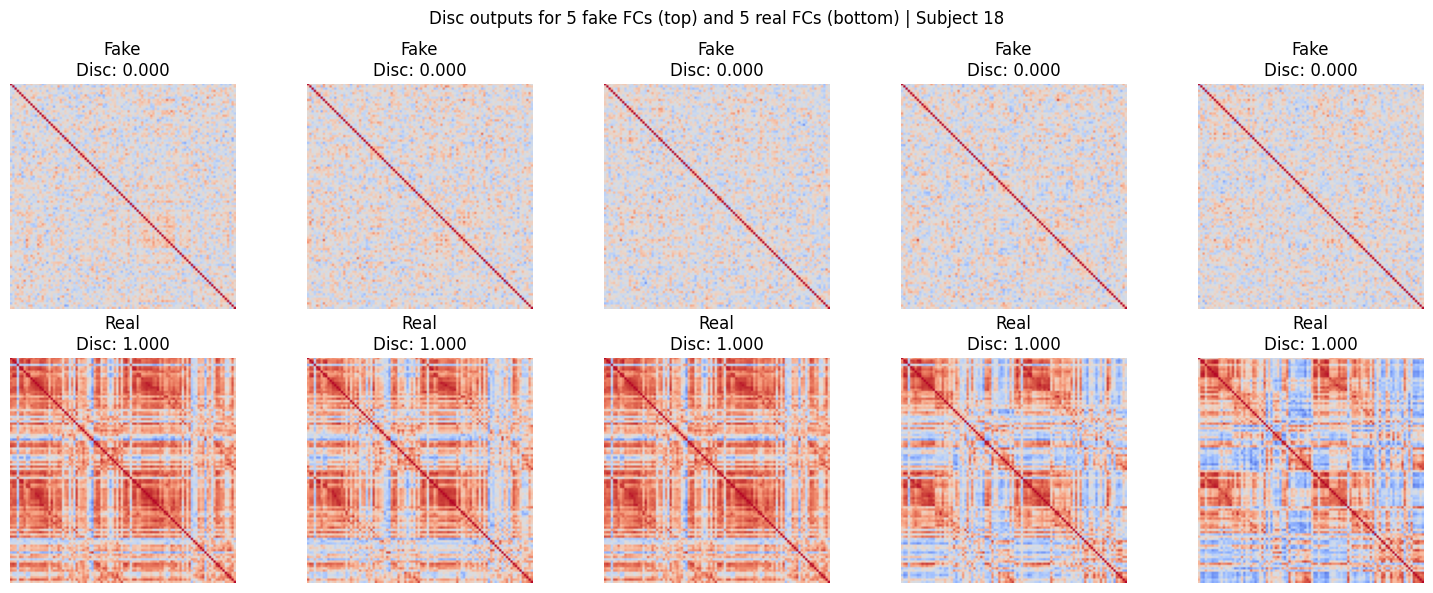

In [13]:

visualise_disc_pred(disc, real_fc, fake_fc, subj=subj)

In [12]:
def test_identity_vs_noise(discriminator, steps=100, batch_size=16, N=100):
    disc = discriminator.to(DEVICE)
    opt = torch.optim.Adam(disc.parameters(), lr=1e-4)
    loss_fn = torch.nn.BCELoss()

    for i in range(steps):
        # Create fake = noise
        fake_fc = torch.randn(batch_size, 1, N, N, device=DEVICE)
        # Create real = identity + slight noise
        real_fc = torch.eye(N, device=DEVICE).unsqueeze(0).repeat(batch_size, 1, 1)
        real_fc += 0.05 * torch.randn_like(real_fc)
        real_fc = real_fc.unsqueeze(1)  # (B,1,N,N)

        y_real = torch.ones(batch_size, 1, device=DEVICE)
        y_fake = torch.zeros(batch_size, 1, device=DEVICE)

        opt.zero_grad()
        pred_real = disc(real_fc)
        pred_fake = disc(fake_fc)
        loss = loss_fn(pred_real, y_real) + loss_fn(pred_fake, y_fake)
        loss.backward()
        opt.step()

        if i % 10 == 0:
            print(f"[{i}] loss={loss.item():.4f} | p(real)={pred_real.mean().item():.3f} | p(fake)={pred_fake.mean().item():.3f}")



disc = FCCNNDisc(sim.model.node_size).to(DEVICE)
test_identity_vs_noise(disc, steps=10000)

[0] loss=1.4056 | p(real)=0.531 | p(fake)=0.538
[10] loss=1.3705 | p(real)=0.521 | p(fake)=0.511
[20] loss=1.3465 | p(real)=0.519 | p(fake)=0.498
[30] loss=1.3331 | p(real)=0.518 | p(fake)=0.491
[40] loss=1.3258 | p(real)=0.505 | p(fake)=0.473
[50] loss=1.3016 | p(real)=0.506 | p(fake)=0.461
[60] loss=1.2895 | p(real)=0.502 | p(fake)=0.451
[70] loss=1.2503 | p(real)=0.512 | p(fake)=0.441
[80] loss=1.2352 | p(real)=0.507 | p(fake)=0.425
[90] loss=1.2082 | p(real)=0.506 | p(fake)=0.409
[100] loss=1.1915 | p(real)=0.511 | p(fake)=0.405
[110] loss=1.1733 | p(real)=0.514 | p(fake)=0.397
[120] loss=1.1398 | p(real)=0.521 | p(fake)=0.386
[130] loss=1.0966 | p(real)=0.530 | p(fake)=0.370
[140] loss=1.0977 | p(real)=0.532 | p(fake)=0.373
[150] loss=1.0695 | p(real)=0.536 | p(fake)=0.359
[160] loss=1.0102 | p(real)=0.545 | p(fake)=0.331
[170] loss=1.0204 | p(real)=0.539 | p(fake)=0.331
[180] loss=0.9788 | p(real)=0.560 | p(fake)=0.329
[190] loss=0.9345 | p(real)=0.566 | p(fake)=0.305
[200] loss=

KeyboardInterrupt: 